# Restore individual models

In [15]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16
import collections
import time
import math

## Load Auto_Encoder_weights

In [16]:
loaded_graph = tf.Graph()
save_model_path = './checkpoints_view_invariant/Au=1_lr=0.0013_nl=2_bs=80.ckpt'
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    Au1w1 = loaded_graph.get_tensor_by_name('conv_layers/conv_weights_1:0').eval()
    Au1b1 = loaded_graph.get_tensor_by_name('conv_layers/bias_1:0').eval()
    Au1w2 = loaded_graph.get_tensor_by_name('conv_layers/conv_weights_2:0').eval()
    Au1b2 = loaded_graph.get_tensor_by_name('conv_layers/bias_2:0').eval()

INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/Au=1_lr=0.0013_nl=2_bs=80.ckpt


In [17]:
loaded_graph = tf.Graph()
save_model_path = './checkpoints_view_invariant/Au=2_lr=0.001_nl=2_bs=80.ckpt'
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    Au2deW1 = loaded_graph.get_tensor_by_name('deconv_layers/deconv_weights_1:0').eval()
    Au2deB1 = loaded_graph.get_tensor_by_name('deconv_layers/debias_1:0').eval()

INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/Au=2_lr=0.001_nl=2_bs=80.ckpt


In [18]:
loaded_graph = tf.Graph()
save_model_path = './checkpoints_view_invariant/Au=3_lr=0.001_nl=2_bs=80.ckpt'
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    Au3deW1 = loaded_graph.get_tensor_by_name('deconv_layers/deconv_weights_1:0').eval()
    Au3deB1 = loaded_graph.get_tensor_by_name('deconv_layers/debias_1:0').eval()
    Au3deW2 = loaded_graph.get_tensor_by_name('deconv_layers/deconv_weights_2:0').eval()
    Au3deB2 = loaded_graph.get_tensor_by_name('deconv_layers/debias_2:0').eval()
    Au3outW = loaded_graph.get_tensor_by_name('output_layer/output_weights:0').eval()
    Au3outb = loaded_graph.get_tensor_by_name('output_layer/outbias_1:0').eval()

INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/Au=3_lr=0.001_nl=2_bs=80.ckpt


In [19]:
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

In [25]:
# Train X
train_x = np.concatenate([gallery_full[:2500, 0], probe_full[:2500, 0]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2500, 3], probe_full[:2500, 3]], axis=0)
train_y = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2500:, 0]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2500:, 3]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2500:, 0]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2500:, 3]
test_y = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5000, 64, 64, 1) train_y (5000, 64, 64, 1)
val_x (646, 64, 64, 1) val_y (646, 64, 64, 1)
test_x (646, 64, 64, 1) test_y (646, 64, 64, 1)


## Build End to End

In [26]:
def conv_layer(inputs_, weight, weight_name, bias, bias_name, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True,
               out_dim=1, conv_kernsize=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
    
    # Weights
    Weights = tf.Variable(weight, name=weight_name)
    
    # Bias
    Bias = tf.Variable(bias, name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    # filter:[filter_height, filter_width, in_channels, out_channels]
    # input:[batch, in_height, in_width, in_channels]
    conv2d = tf.nn.bias_add(tf.nn.conv2d(inputs_, Weights, stride, padding='SAME', name=conv_name), Bias)
    
    # Now 28x28x
    if add_bacth_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
        
    # add activation function
    conv2d = tf.nn.relu(conv2d, name=relu_name)
    
    # add Max pooling
    conv2d_maxpool = tf.nn.max_pool(conv2d, [1,pool_size[0],pool_size[1],1],\
                                    [1,pool_strides[0],pool_strides[1],1], padding='SAME', name=pool_name)
                    
    conv2d_maxpool = tf.layers.dropout(conv2d_maxpool, rate=keep_prob)

    return conv2d_maxpool

def deconv_layer(encoded, up_name, weight, weight_name, bias, bias_name, de_conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True,
                 up_size=[(2,2),(4,4),(5,5),(6,6)], out_dim=1, conv_kernsize=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    
    # Weights
    Weights = tf.Variable(weight, name=weight_name)
    
    # Bias
    Bias = tf.Variable(bias, name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    conv2d = tf.nn.bias_add(tf.nn.conv2d(upsample, Weights, stride, padding='SAME', name=de_conv_name),\
                   Bias)
    
    if add_batch_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
    
    conv2d = tf.nn.relu(conv2d, name=relu_name)
    
    conv2d = tf.layers.dropout(conv2d, rate=keep_prob)
    
    return conv2d

def output_layer(conv2d, weight, weight_name, bias, bias_name, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 out_dim=1, conv_kernsize=(3,3), conv_strides=(1,1)):
    # Weights
    Weights = tf.Variable(weight, name=weight_name)
    
    # Bias
    Bias = tf.Variable(bias, name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    logits = tf.nn.bias_add(tf.nn.conv2d(conv2d, Weights, stride, padding='SAME', name=logits_name),\
                   Bias)
    
    if add_batch_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [27]:
conv_kern_size = (4,4)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(64,64)]
de_kern_size = (4,4)
de_conv_strides = (1,1)
out_kern_size = (4,4)
out_strides = (1,1)


g = tf.Graph()
tf.reset_default_graph()
with g.as_default():
    
    Au1_Weights_1 = tf.convert_to_tensor(Au1w1, dtype=tf.float32)
    Au1_Bias_1 = tf.convert_to_tensor(Au1b1, dtype=tf.float32)
    Au1_Weights_2 = tf.convert_to_tensor(Au1w2, dtype=tf.float32)
    Au1_Bias_2 = tf.convert_to_tensor(Au1b2, dtype=tf.float32)
    Au2_deWeights_1 = tf.convert_to_tensor(Au2deW1, dtype=tf.float32)
    Au2_deBias_1 = tf.convert_to_tensor(Au2deB1, dtype=tf.float32)
    Au3_deWeights_1 = tf.convert_to_tensor(Au3deW1, dtype=tf.float32)
    Au3_deBias_1 = tf.convert_to_tensor(Au3deB1, dtype=tf.float32)
    Au3_DeWeights_2 = tf.convert_to_tensor(Au3deW2, dtype=tf.float32)
    Au3_DeBiass_2 = tf.convert_to_tensor(Au3deB2, dtype=tf.float32)
    Au3_OutWeights = tf.convert_to_tensor(Au3outW, dtype=tf.float32)
    Au3_OutBias = tf.convert_to_tensor(Au3outb, dtype=tf.float32)
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    training = tf.placeholder(tf.bool, name='training')
    inputs = tf.placeholder(tf.float32, [None, 64, 64, 1], name='inputs')
    targets = tf.placeholder(tf.float32, [None, 64, 64, 1], name='targets')

    # 64x64 -- 32x32
    with tf.name_scope('conv_layer'):
        # outdim 1 -- 16
        maxpool_1 = conv_layer(inputs, Au1_Weights_1, 'weight_1', Au1_Bias_1, 'bias_1', 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=training, out_dim=16, conv_kernsize=conv_kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
    
    with tf.name_scope('hidden_layers'):
        # Now 32x32x16 Hidden Layer 1 Au_1
        # outdim 16 -- 8
        stride = [1, conv_strides[0], conv_strides[1], 1]

        Au1Weights2 = tf.Variable(Au1_Weights_2, name='h_weight_1')
        Au1Bias2 = tf.Variable(Au1_Bias_2, name='h_bias_1')
        conv_hidden_1 = tf.nn.bias_add(tf.nn.conv2d(maxpool_1, Au1Weights2, stride, padding='SAME', name='hidden_1'), Au1Bias2)

        # Now 32x32x8 Hidden Layer 2 Au_2
        # outdim 8 -- 8
        Au2deWeights1 = tf.Variable(Au2_deWeights_1, name='h_weight_2')
        Au2deBias1 = tf.Variable(Au2_deBias_1, name='h_bias_2')
        conv_hidden_2 = tf.nn.bias_add(tf.nn.conv2d(conv_hidden_1, Au2deWeights1, stride, padding='SAME', name='hidden_2'), Au2deBias1)

        # Now 32x32x8 Hidden Layer 3 Au_3
        # outdim 8 -- 8
        Au3deWeights1 = tf.Variable(Au3_deWeights_1, name='h_weight_3')
        Au3deBias1 = tf.Variable(Au3_deBias_1, name='h_bias_3')
        conv_hidden_3 = tf.nn.bias_add(tf.nn.conv2d(conv_hidden_2, Au3deWeights1, stride, padding='SAME', name='hidden_3'), Au3deBias1)
    
    with tf.name_scope('deconv_layers'):
        # Now 32x32x8 Deconv Layer
        # outdim 8 -- 16
        deconv_1 = deconv_layer(conv_hidden_3, 'up_1', Au3_DeWeights_2, 'deWeight_1', Au3_DeBiass_2, 'deBias_1', 'deconv_1', 'debn_1', 'derelu_1', add_batch_norm=True, is_training=training,
                     up_size=up_size[0], out_dim=16, conv_kernsize=de_kern_size, conv_strides=de_conv_strides, keep_prob=keep_p)
   
    with tf.name_scope('output_layer'):
        # Now 64x64x16 Output Layer
        # outdim 16 -- 1
        logits, decoded = output_layer(deconv_1, Au3_OutWeights, 'outWeight', Au3_OutBias, 'outBias', 'logits', 'outbn', 'output', add_batch_norm=True, is_training=training, 
                                       out_dim=1, conv_kernsize=out_kern_size, conv_strides=out_strides)

    # Now 64x64x1 Output
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    with tf.name_scope('saver'):
        saver = tf.train.Saver()

In [28]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.08)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

Epoch: 1/1800,  Iteration: 25,  Train loss: 0.418,       0.0s /batch.  Train Accuracy: %69.807
Epoch: 1/1800,  Iteration: 50,  Train loss: 0.295,       0.0s /batch.  Train Accuracy: %73.145
Epoch: 2/1800,  Iteration: 75,  Train loss: 0.259,       0.0s /batch.  Train Accuracy: %77.744

Validation loss: 0.312,  Validation accuracy: 71.796,

Epoch: 2/1800,  Iteration: 100,  Train loss: 0.257,       0.0s /batch.  Train Accuracy: %78.799
Epoch: 3/1800,  Iteration: 125,  Train loss: 0.238,       0.0s /batch.  Train Accuracy: %81.115
Epoch: 3/1800,  Iteration: 150,  Train loss: 0.242,       0.0s /batch.  Train Accuracy: %81.323

Validation loss: 0.307,  Validation accuracy: 72.349,

Epoch: 3/1800,  Iteration: 175,  Train loss: 0.235,       0.0s /batch.  Train Accuracy: %82.373
Epoch: 4/1800,  Iteration: 200,  Train loss: 0.247,       0.0s /batch.  Train Accuracy: %82.795
Epoch: 4/1800,  Iteration: 225,  Train loss: 0.248,       0.0s /batch.  Train Accuracy: %83.650

Validation loss: 0.296,  V

Epoch: 30/1800,  Iteration: 1825,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %95.901
Epoch: 30/1800,  Iteration: 1850,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %96.318
Epoch: 31/1800,  Iteration: 1875,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %96.407

Validation loss: 0.302,  Validation accuracy: 74.938,

Epoch: 31/1800,  Iteration: 1900,  Train loss: 0.235,       0.0s /batch.  Train Accuracy: %96.602
Epoch: 32/1800,  Iteration: 1925,  Train loss: 0.225,       0.0s /batch.  Train Accuracy: %96.650
Epoch: 32/1800,  Iteration: 1950,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %96.993

Validation loss: 0.296,  Validation accuracy: 76.469,

Epoch: 32/1800,  Iteration: 1975,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %96.656
Epoch: 33/1800,  Iteration: 2000,  Train loss: 0.225,       0.0s /batch.  Train Accuracy: %95.036
Epoch: 33/1800,  Iteration: 2025,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %97.021

Valid

Epoch: 59/1800,  Iteration: 3600,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %97.912

Validation loss: 0.292,  Validation accuracy: 76.601,

Epoch: 59/1800,  Iteration: 3625,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %97.907
Epoch: 59/1800,  Iteration: 3650,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %97.798
Epoch: 60/1800,  Iteration: 3675,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %96.277

Validation loss: 0.304,  Validation accuracy: 75.153,

Epoch: 60/1800,  Iteration: 3700,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %98.392
Epoch: 61/1800,  Iteration: 3725,  Train loss: 0.225,       0.0s /batch.  Train Accuracy: %97.662
Epoch: 61/1800,  Iteration: 3750,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %98.249

Validation loss: 0.302,  Validation accuracy: 76.354,

Epoch: 61/1800,  Iteration: 3775,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %98.071
Epoch: 62/1800,  Iteration: 3800,  Train loss: 0

Epoch: 87/1800,  Iteration: 5350,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %98.836
Epoch: 87/1800,  Iteration: 5375,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %98.967
Epoch: 88/1800,  Iteration: 5400,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.053

Validation loss: 0.298,  Validation accuracy: 76.839,

Epoch: 88/1800,  Iteration: 5425,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %98.988
Epoch: 88/1800,  Iteration: 5450,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %98.860
Epoch: 89/1800,  Iteration: 5475,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %98.520

Validation loss: 0.303,  Validation accuracy: 75.583,

Epoch: 89/1800,  Iteration: 5500,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %98.363
Epoch: 90/1800,  Iteration: 5525,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.170
Epoch: 90/1800,  Iteration: 5550,  Train loss: 0.215,       0.0s /batch.  Train Accuracy: %98.669

Valid

Epoch: 115/1800,  Iteration: 7125,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.491

Validation loss: 0.304,  Validation accuracy: 77.007,

Epoch: 116/1800,  Iteration: 7150,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.488
Epoch: 116/1800,  Iteration: 7175,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.532
Epoch: 117/1800,  Iteration: 7200,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.705

Validation loss: 0.308,  Validation accuracy: 76.695,

Epoch: 117/1800,  Iteration: 7225,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.681
Epoch: 117/1800,  Iteration: 7250,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.482
Epoch: 118/1800,  Iteration: 7275,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.446

Validation loss: 0.315,  Validation accuracy: 76.178,

Epoch: 118/1800,  Iteration: 7300,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.561
Epoch: 119/1800,  Iteration: 7325,  Trai

Epoch: 144/1800,  Iteration: 8875,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.789
Epoch: 144/1800,  Iteration: 8900,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.770
Epoch: 144/1800,  Iteration: 8925,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.666

Validation loss: 0.315,  Validation accuracy: 76.669,

Epoch: 145/1800,  Iteration: 8950,  Train loss: 0.215,       0.0s /batch.  Train Accuracy: %99.601
Epoch: 145/1800,  Iteration: 8975,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.540
Epoch: 146/1800,  Iteration: 9000,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.808

Validation loss: 0.311,  Validation accuracy: 76.738,

Epoch: 146/1800,  Iteration: 9025,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %99.778
Epoch: 146/1800,  Iteration: 9050,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.780
Epoch: 147/1800,  Iteration: 9075,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.7

/usr/home/rez/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 170/1800,  Iteration: 10525,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.641
Epoch: 171/1800,  Iteration: 10550,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.878
Epoch: 171/1800,  Iteration: 10575,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %99.848

Validation loss: 0.312,  Validation accuracy: 75.954,

Epoch: 171/1800,  Iteration: 10600,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.879
Epoch: 172/1800,  Iteration: 10625,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.857
Epoch: 172/1800,  Iteration: 10650,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.740

Validation loss: 0.319,  Validation accuracy: 75.455,

Epoch: 173/1800,  Iteration: 10675,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.871
Epoch: 173/1800,  Iteration: 10700,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.862
Epoch: 173/1800,  Iteration: 10725,  Train loss: 0.222,       0.0s /batch.  Train Accura

Epoch: 198/1800,  Iteration: 12275,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.901
Epoch: 199/1800,  Iteration: 12300,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.858

Validation loss: 0.322,  Validation accuracy: 76.756,

Epoch: 199/1800,  Iteration: 12325,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.871
Epoch: 200/1800,  Iteration: 12350,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.848
Epoch: 200/1800,  Iteration: 12375,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.907

Validation loss: 0.320,  Validation accuracy: 75.800,

Epoch: 200/1800,  Iteration: 12400,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.907
Epoch: 201/1800,  Iteration: 12425,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.875
Epoch: 201/1800,  Iteration: 12450,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.868

Validation loss: 0.308,  Validation accuracy: 75.868,

Epoch: 202/1800,  Iteration: 124

Epoch: 227/1800,  Iteration: 14025,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.856

Validation loss: 0.328,  Validation accuracy: 76.376,

Epoch: 227/1800,  Iteration: 14050,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.909
Epoch: 228/1800,  Iteration: 14075,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.918
Epoch: 228/1800,  Iteration: 14100,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.884

Validation loss: 0.329,  Validation accuracy: 76.758,

Epoch: 228/1800,  Iteration: 14125,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.923
Epoch: 229/1800,  Iteration: 14150,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.850
Epoch: 229/1800,  Iteration: 14175,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.925

Validation loss: 0.322,  Validation accuracy: 75.691,

Epoch: 230/1800,  Iteration: 14200,  Train loss: 0.225,       0.0s /batch.  Train Accuracy: %99.944
Epoch: 230/1800,  Iteration: 142

Epoch: 255/1800,  Iteration: 15775,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.906
Epoch: 255/1800,  Iteration: 15800,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.946
Epoch: 256/1800,  Iteration: 15825,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.912

Validation loss: 0.334,  Validation accuracy: 75.512,

Epoch: 256/1800,  Iteration: 15850,  Train loss: 0.231,       0.0s /batch.  Train Accuracy: %99.948
Epoch: 257/1800,  Iteration: 15875,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.939
Epoch: 257/1800,  Iteration: 15900,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %99.943

Validation loss: 0.331,  Validation accuracy: 76.586,

Epoch: 257/1800,  Iteration: 15925,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.945
Epoch: 258/1800,  Iteration: 15950,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.818
Epoch: 258/1800,  Iteration: 15975,  Train loss: 0.229,       0.0s /batch.  Train Accura

Epoch: 283/1800,  Iteration: 17525,  Train loss: 0.229,       0.0s /batch.  Train Accuracy: %99.946
Epoch: 284/1800,  Iteration: 17550,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.934

Validation loss: 0.319,  Validation accuracy: 76.077,

Epoch: 284/1800,  Iteration: 17575,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.957
Epoch: 284/1800,  Iteration: 17600,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.944
Epoch: 285/1800,  Iteration: 17625,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.823

Validation loss: 0.334,  Validation accuracy: 75.313,

Epoch: 285/1800,  Iteration: 17650,  Train loss: 0.229,       0.0s /batch.  Train Accuracy: %99.954
Epoch: 286/1800,  Iteration: 17675,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.955
Epoch: 286/1800,  Iteration: 17700,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.948

Validation loss: 0.327,  Validation accuracy: 76.570,

Epoch: 286/1800,  Iteration: 177

Epoch: 311/1800,  Iteration: 19275,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.934

Validation loss: 0.317,  Validation accuracy: 76.798,

Epoch: 312/1800,  Iteration: 19300,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.930
Epoch: 312/1800,  Iteration: 19325,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.961
Epoch: 313/1800,  Iteration: 19350,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.942

Validation loss: 0.314,  Validation accuracy: 76.222,

Epoch: 313/1800,  Iteration: 19375,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.910
Epoch: 313/1800,  Iteration: 19400,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.930
Epoch: 314/1800,  Iteration: 19425,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.912

Validation loss: 0.330,  Validation accuracy: 75.560,

Epoch: 314/1800,  Iteration: 19450,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.944
Epoch: 315/1800,  Iteration: 194

Epoch: 340/1800,  Iteration: 21025,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.963
Epoch: 340/1800,  Iteration: 21050,  Train loss: 0.213,       0.0s /batch.  Train Accuracy: %99.839
Epoch: 340/1800,  Iteration: 21075,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.915

Validation loss: 0.318,  Validation accuracy: 76.870,

Epoch: 341/1800,  Iteration: 21100,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.952
Epoch: 341/1800,  Iteration: 21125,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.948
Epoch: 342/1800,  Iteration: 21150,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.960

Validation loss: 0.312,  Validation accuracy: 76.343,

Epoch: 342/1800,  Iteration: 21175,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.953
Epoch: 342/1800,  Iteration: 21200,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.923
Epoch: 343/1800,  Iteration: 21225,  Train loss: 0.219,       0.0s /batch.  Train Accura

Epoch: 368/1800,  Iteration: 22775,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.917
Epoch: 368/1800,  Iteration: 22800,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.960

Validation loss: 0.329,  Validation accuracy: 75.453,

Epoch: 369/1800,  Iteration: 22825,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.966
Epoch: 369/1800,  Iteration: 22850,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.952
Epoch: 369/1800,  Iteration: 22875,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.953

Validation loss: 0.322,  Validation accuracy: 76.816,

Epoch: 370/1800,  Iteration: 22900,  Train loss: 0.215,       0.0s /batch.  Train Accuracy: %99.953
Epoch: 370/1800,  Iteration: 22925,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.895
Epoch: 371/1800,  Iteration: 22950,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.966

Validation loss: 0.312,  Validation accuracy: 76.454,

Epoch: 371/1800,  Iteration: 229

Epoch: 396/1800,  Iteration: 24525,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %99.961

Validation loss: 0.325,  Validation accuracy: 76.094,

Epoch: 396/1800,  Iteration: 24550,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.981
Epoch: 397/1800,  Iteration: 24575,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.972
Epoch: 397/1800,  Iteration: 24600,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.900

Validation loss: 0.334,  Validation accuracy: 75.514,

Epoch: 398/1800,  Iteration: 24625,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.970
Epoch: 398/1800,  Iteration: 24650,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.972
Epoch: 398/1800,  Iteration: 24675,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.976

Validation loss: 0.326,  Validation accuracy: 76.581,

Epoch: 399/1800,  Iteration: 24700,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.949
Epoch: 399/1800,  Iteration: 247

Epoch: 424/1800,  Iteration: 26275,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.944
Epoch: 425/1800,  Iteration: 26300,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.932
Epoch: 425/1800,  Iteration: 26325,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.976

Validation loss: 0.322,  Validation accuracy: 75.778,

Epoch: 425/1800,  Iteration: 26350,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.975
Epoch: 426/1800,  Iteration: 26375,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.953
Epoch: 426/1800,  Iteration: 26400,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.933

Validation loss: 0.333,  Validation accuracy: 75.782,

Epoch: 427/1800,  Iteration: 26425,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.897
Epoch: 427/1800,  Iteration: 26450,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.966
Epoch: 428/1800,  Iteration: 26475,  Train loss: 0.214,       0.0s /batch.  Train Accura

Epoch: 452/1800,  Iteration: 28000,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.969
Epoch: 453/1800,  Iteration: 28025,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.958
Epoch: 453/1800,  Iteration: 28050,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.937

Validation loss: 0.321,  Validation accuracy: 76.771,

Epoch: 453/1800,  Iteration: 28075,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.962
Epoch: 454/1800,  Iteration: 28100,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.906
Epoch: 454/1800,  Iteration: 28125,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.976

Validation loss: 0.319,  Validation accuracy: 75.657,

Epoch: 455/1800,  Iteration: 28150,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.975
Epoch: 455/1800,  Iteration: 28175,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.922
Epoch: 455/1800,  Iteration: 28200,  Train loss: 0.218,       0.0s /batch.  Train Accura

Epoch: 480/1800,  Iteration: 29750,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.961
Epoch: 481/1800,  Iteration: 29775,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.978

Validation loss: 0.331,  Validation accuracy: 75.813,

Epoch: 481/1800,  Iteration: 29800,  Train loss: 0.231,       0.0s /batch.  Train Accuracy: %99.982
Epoch: 482/1800,  Iteration: 29825,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.966
Epoch: 482/1800,  Iteration: 29850,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %99.959

Validation loss: 0.323,  Validation accuracy: 76.803,

Epoch: 482/1800,  Iteration: 29875,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.977
Epoch: 483/1800,  Iteration: 29900,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.926
Epoch: 483/1800,  Iteration: 29925,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.978

Validation loss: 0.319,  Validation accuracy: 75.667,

Epoch: 484/1800,  Iteration: 299

Epoch: 509/1800,  Iteration: 31500,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.963

Validation loss: 0.324,  Validation accuracy: 76.152,

Epoch: 509/1800,  Iteration: 31525,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.984
Epoch: 509/1800,  Iteration: 31550,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.978
Epoch: 510/1800,  Iteration: 31575,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.888

Validation loss: 0.337,  Validation accuracy: 75.510,

Epoch: 510/1800,  Iteration: 31600,  Train loss: 0.229,       0.0s /batch.  Train Accuracy: %99.985
Epoch: 511/1800,  Iteration: 31625,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.986
Epoch: 511/1800,  Iteration: 31650,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.977

Validation loss: 0.327,  Validation accuracy: 76.696,

Epoch: 511/1800,  Iteration: 31675,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.982
Epoch: 512/1800,  Iteration: 317

Epoch: 537/1800,  Iteration: 33250,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.958
Epoch: 537/1800,  Iteration: 33275,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.978
Epoch: 538/1800,  Iteration: 33300,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.973

Validation loss: 0.316,  Validation accuracy: 76.084,

Epoch: 538/1800,  Iteration: 33325,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.985
Epoch: 538/1800,  Iteration: 33350,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.966
Epoch: 539/1800,  Iteration: 33375,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.910

Validation loss: 0.337,  Validation accuracy: 75.565,

Epoch: 539/1800,  Iteration: 33400,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.958
Epoch: 540/1800,  Iteration: 33425,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.983
Epoch: 540/1800,  Iteration: 33450,  Train loss: 0.213,       0.0s /batch.  Train Accura

Epoch: 565/1800,  Iteration: 35000,  Train loss: 0.213,       0.0s /batch.  Train Accuracy: %99.961
Epoch: 565/1800,  Iteration: 35025,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.969

Validation loss: 0.323,  Validation accuracy: 76.807,

Epoch: 566/1800,  Iteration: 35050,  Train loss: 0.213,       0.0s /batch.  Train Accuracy: %99.968
Epoch: 566/1800,  Iteration: 35075,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.956
Epoch: 567/1800,  Iteration: 35100,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.991

Validation loss: 0.317,  Validation accuracy: 76.181,

Epoch: 567/1800,  Iteration: 35125,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.985
Epoch: 567/1800,  Iteration: 35150,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.964
Epoch: 568/1800,  Iteration: 35175,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.929

Validation loss: 0.335,  Validation accuracy: 75.903,

Epoch: 568/1800,  Iteration: 352

Epoch: 593/1800,  Iteration: 36750,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.982

Validation loss: 0.331,  Validation accuracy: 75.501,

Epoch: 594/1800,  Iteration: 36775,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.978
Epoch: 594/1800,  Iteration: 36800,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.968
Epoch: 594/1800,  Iteration: 36825,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.976

Validation loss: 0.326,  Validation accuracy: 76.751,

Epoch: 595/1800,  Iteration: 36850,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.962
Epoch: 595/1800,  Iteration: 36875,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.957
Epoch: 596/1800,  Iteration: 36900,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.986

Validation loss: 0.315,  Validation accuracy: 76.285,

Epoch: 596/1800,  Iteration: 36925,  Train loss: 0.232,       0.0s /batch.  Train Accuracy: %99.977
Epoch: 596/1800,  Iteration: 369

Epoch: 621/1800,  Iteration: 38500,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.991
Epoch: 622/1800,  Iteration: 38525,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.978
Epoch: 622/1800,  Iteration: 38550,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.957

Validation loss: 0.335,  Validation accuracy: 75.513,

Epoch: 623/1800,  Iteration: 38575,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.987
Epoch: 623/1800,  Iteration: 38600,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.987
Epoch: 623/1800,  Iteration: 38625,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.988

Validation loss: 0.328,  Validation accuracy: 76.607,

Epoch: 624/1800,  Iteration: 38650,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.980
Epoch: 624/1800,  Iteration: 38675,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.971
Epoch: 625/1800,  Iteration: 38700,  Train loss: 0.222,       0.0s /batch.  Train Accura

Epoch: 650/1800,  Iteration: 40250,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.963
Epoch: 650/1800,  Iteration: 40275,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.982

Validation loss: 0.325,  Validation accuracy: 75.881,

Epoch: 650/1800,  Iteration: 40300,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.988
Epoch: 651/1800,  Iteration: 40325,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.977
Epoch: 651/1800,  Iteration: 40350,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.959

Validation loss: 0.337,  Validation accuracy: 75.737,

Epoch: 652/1800,  Iteration: 40375,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.932
Epoch: 652/1800,  Iteration: 40400,  Train loss: 0.226,       0.0s /batch.  Train Accuracy: %99.982
Epoch: 653/1800,  Iteration: 40425,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.980

Validation loss: 0.329,  Validation accuracy: 76.450,

Epoch: 653/1800,  Iteration: 404

Epoch: 678/1800,  Iteration: 42000,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.972

Validation loss: 0.326,  Validation accuracy: 76.635,

Epoch: 678/1800,  Iteration: 42025,  Train loss: 0.214,       0.0s /batch.  Train Accuracy: %99.975
Epoch: 679/1800,  Iteration: 42050,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %99.928
Epoch: 679/1800,  Iteration: 42075,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.984

Validation loss: 0.323,  Validation accuracy: 75.699,

Epoch: 680/1800,  Iteration: 42100,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.984
Epoch: 680/1800,  Iteration: 42125,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.957
Epoch: 680/1800,  Iteration: 42150,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.968

Validation loss: 0.333,  Validation accuracy: 76.123,

Epoch: 681/1800,  Iteration: 42175,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.987
Epoch: 681/1800,  Iteration: 422

Epoch: 706/1800,  Iteration: 43750,  Train loss: 0.231,       0.0s /batch.  Train Accuracy: %99.990
Epoch: 707/1800,  Iteration: 43775,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %99.980
Epoch: 707/1800,  Iteration: 43800,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %99.980

Validation loss: 0.328,  Validation accuracy: 76.618,

Epoch: 707/1800,  Iteration: 43825,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.981
Epoch: 708/1800,  Iteration: 43850,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.963
Epoch: 708/1800,  Iteration: 43875,  Train loss: 0.228,       0.0s /batch.  Train Accuracy: %99.985

Validation loss: 0.321,  Validation accuracy: 75.635,

Epoch: 709/1800,  Iteration: 43900,  Train loss: 0.230,       0.0s /batch.  Train Accuracy: %99.977
Epoch: 709/1800,  Iteration: 43925,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.988
Epoch: 709/1800,  Iteration: 43950,  Train loss: 0.218,       0.0s /batch.  Train Accura

Epoch: 734/1800,  Iteration: 45500,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.978
Epoch: 735/1800,  Iteration: 45525,  Train loss: 0.215,       0.0s /batch.  Train Accuracy: %99.936

Validation loss: 0.338,  Validation accuracy: 75.559,

Epoch: 735/1800,  Iteration: 45550,  Train loss: 0.229,       0.0s /batch.  Train Accuracy: %99.989
Epoch: 736/1800,  Iteration: 45575,  Train loss: 0.223,       0.0s /batch.  Train Accuracy: %99.991
Epoch: 736/1800,  Iteration: 45600,  Train loss: 0.216,       0.0s /batch.  Train Accuracy: %99.978

Validation loss: 0.332,  Validation accuracy: 76.550,

Epoch: 736/1800,  Iteration: 45625,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.985
Epoch: 737/1800,  Iteration: 45650,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: %99.974
Epoch: 737/1800,  Iteration: 45675,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.987

Validation loss: 0.321,  Validation accuracy: 75.649,

Epoch: 738/1800,  Iteration: 457

Epoch: 763/1800,  Iteration: 47250,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %99.979

Validation loss: 0.321,  Validation accuracy: 76.265,

Epoch: 763/1800,  Iteration: 47275,  Train loss: 0.219,       0.0s /batch.  Train Accuracy: %99.990
Epoch: 763/1800,  Iteration: 47300,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.982
Epoch: 764/1800,  Iteration: 47325,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %99.942

Validation loss: 0.338,  Validation accuracy: 75.637,

Epoch: 764/1800,  Iteration: 47350,  Train loss: 0.220,       0.0s /batch.  Train Accuracy: %99.965
Epoch: 765/1800,  Iteration: 47375,  Train loss: 0.224,       0.0s /batch.  Train Accuracy: %99.989


KeyboardInterrupt: 

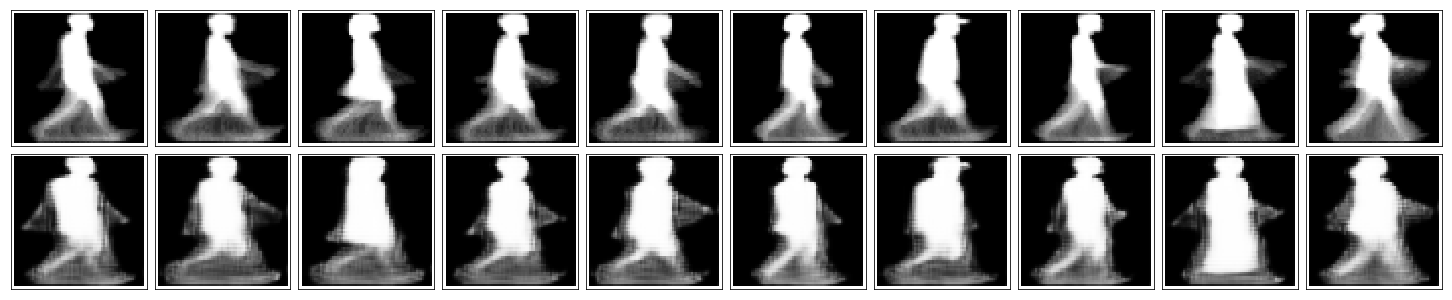

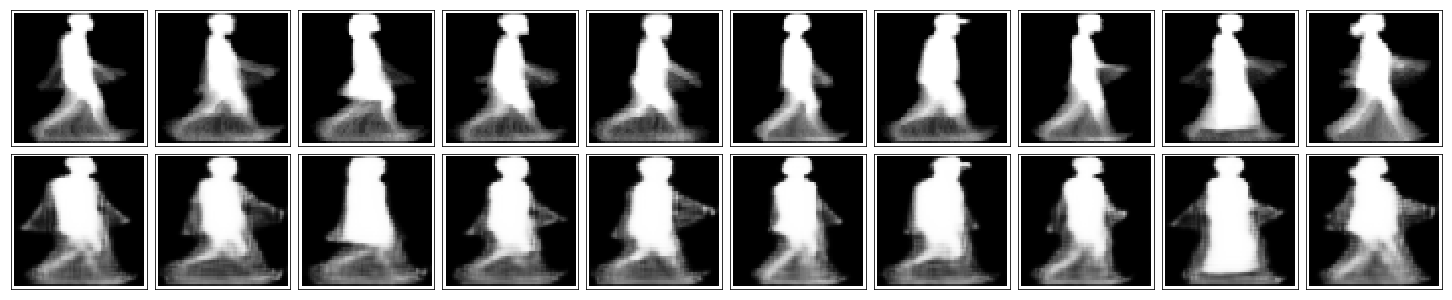

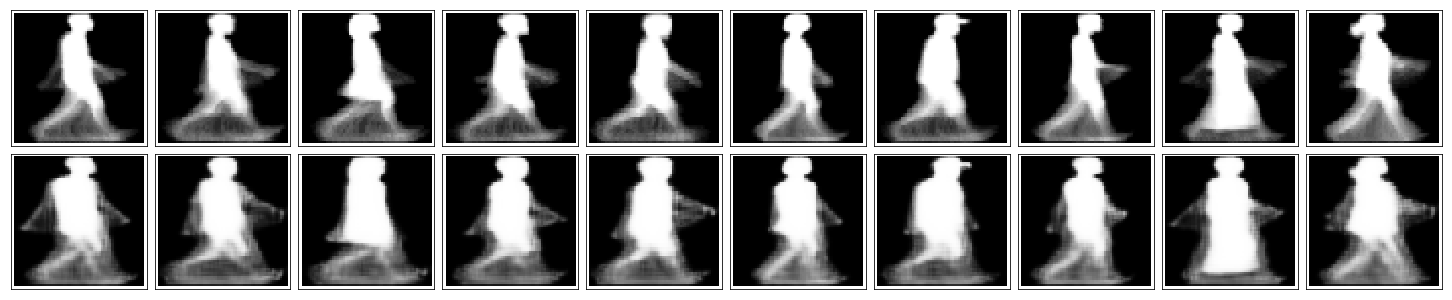

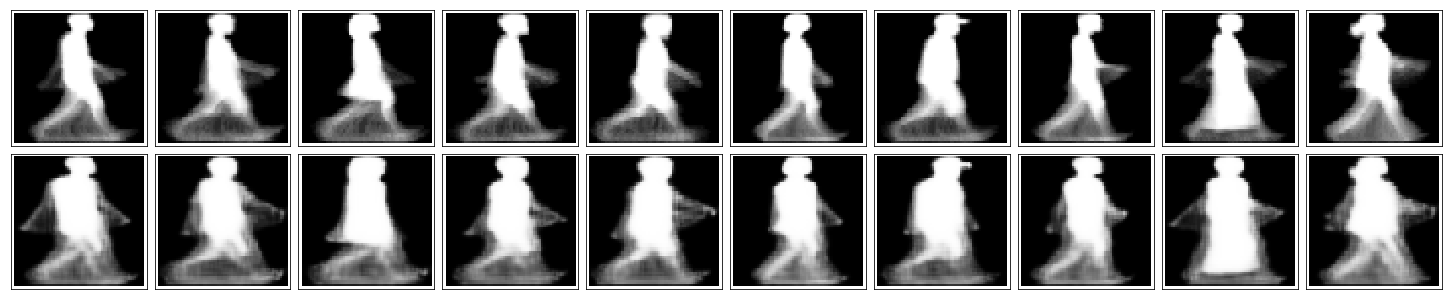

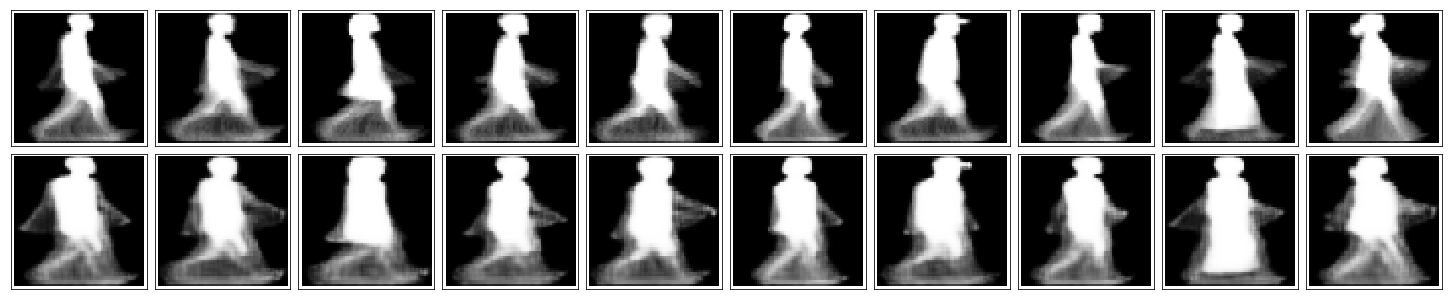

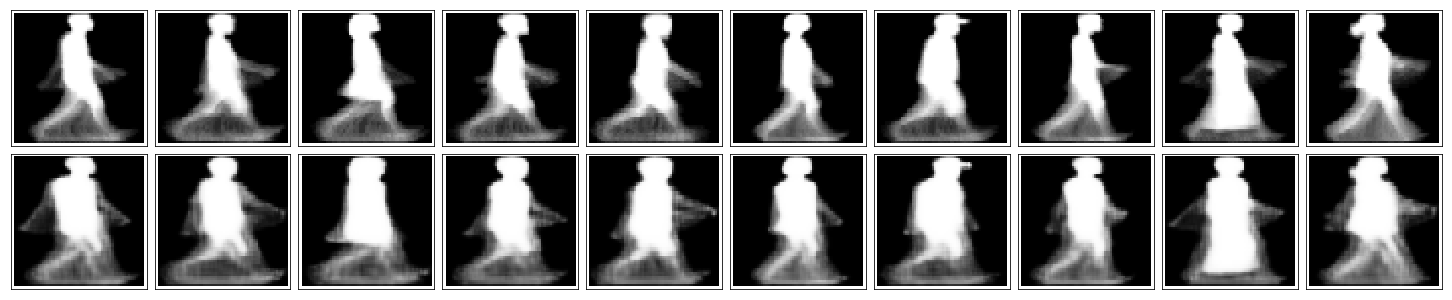

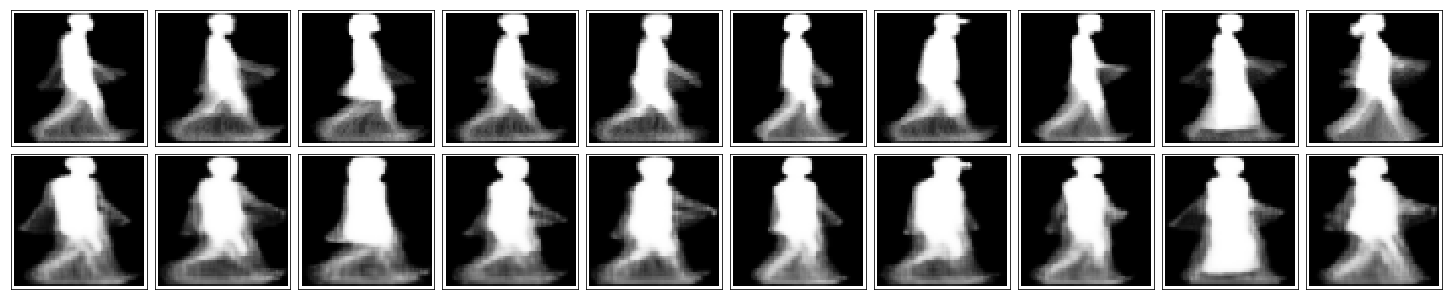

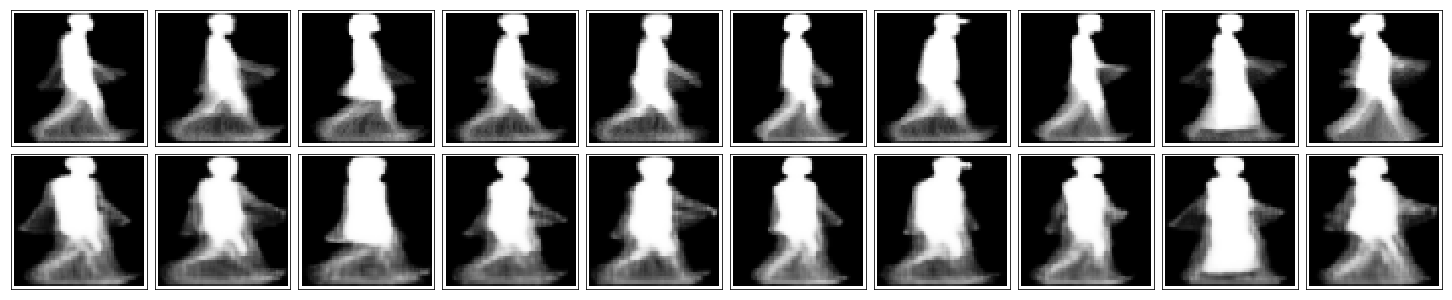

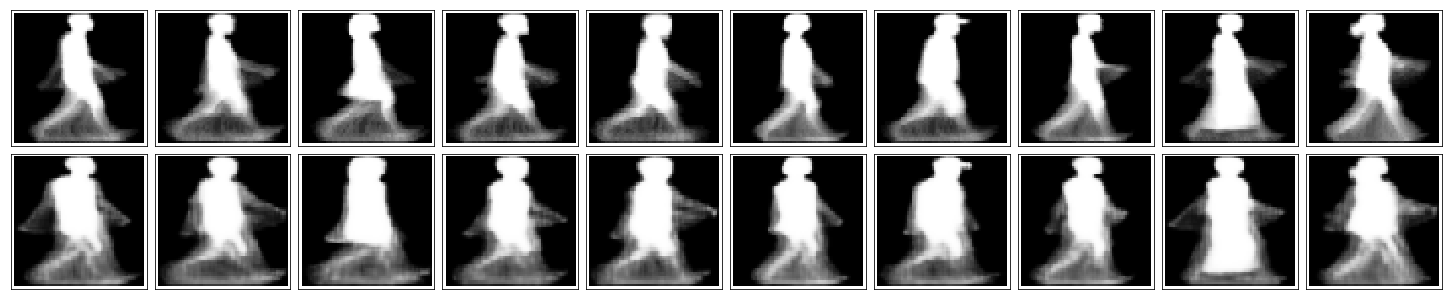

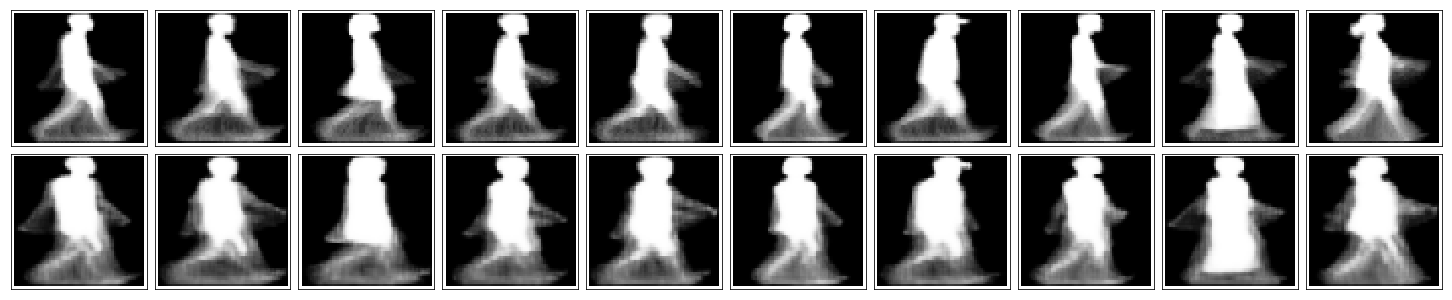

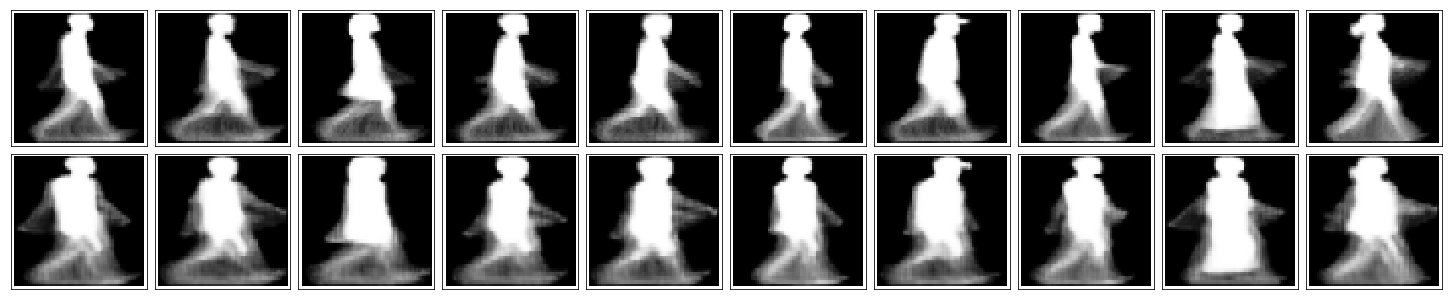

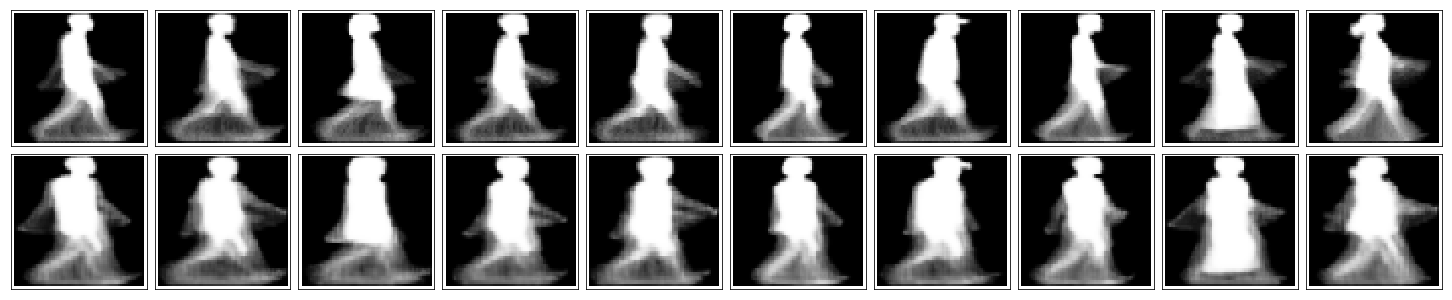

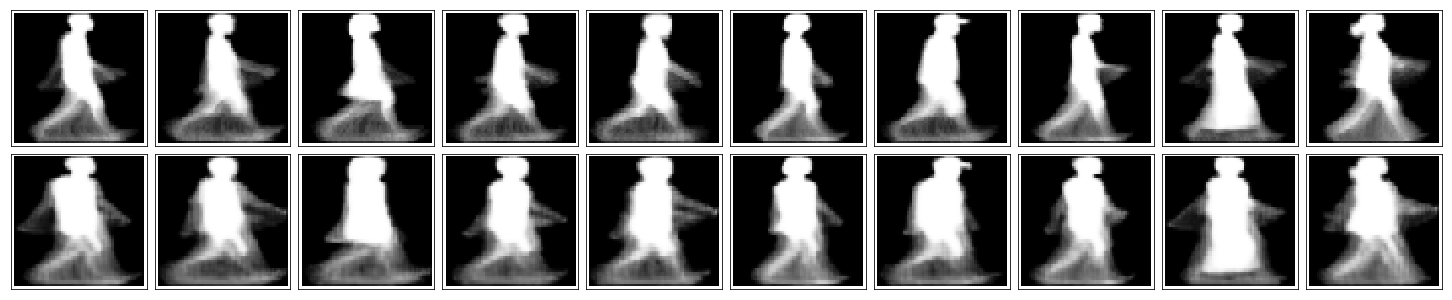

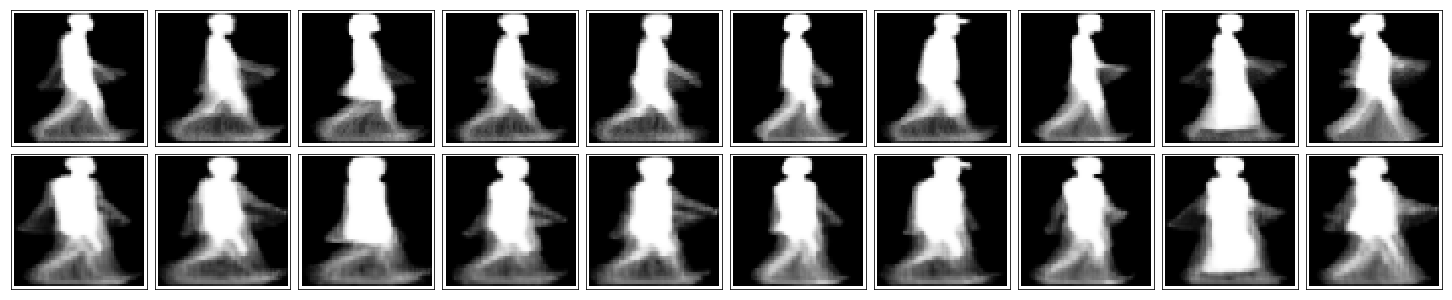

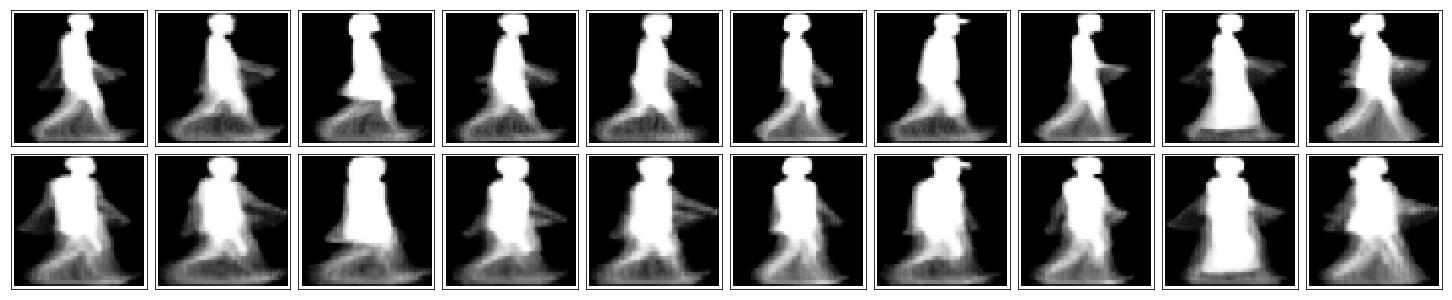

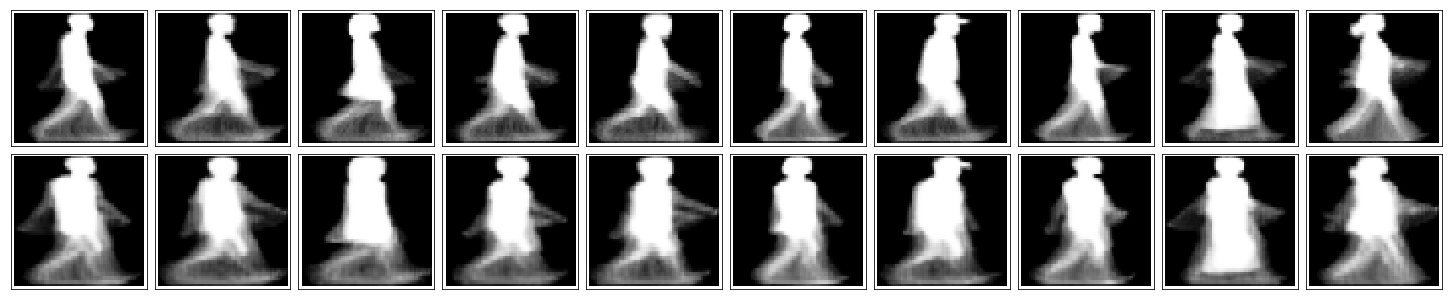

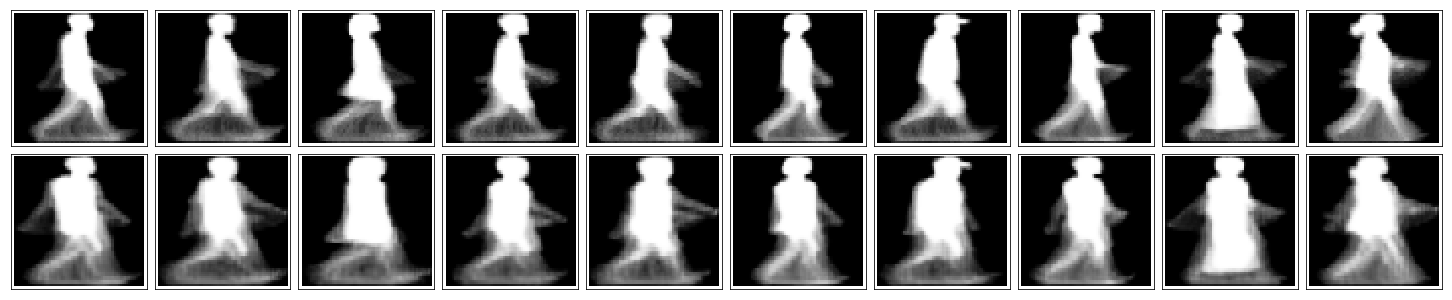

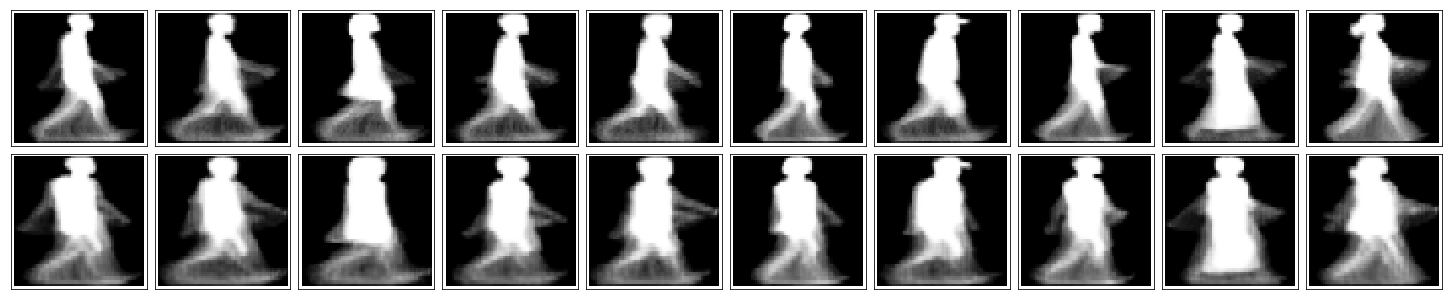

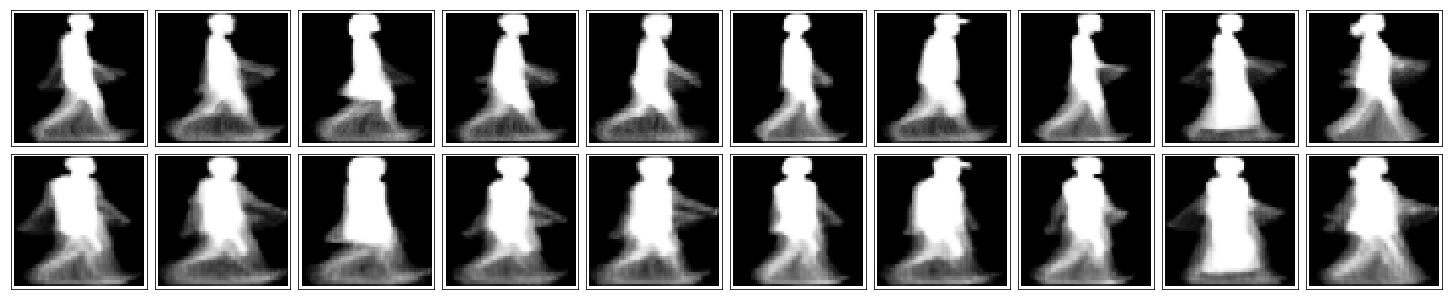

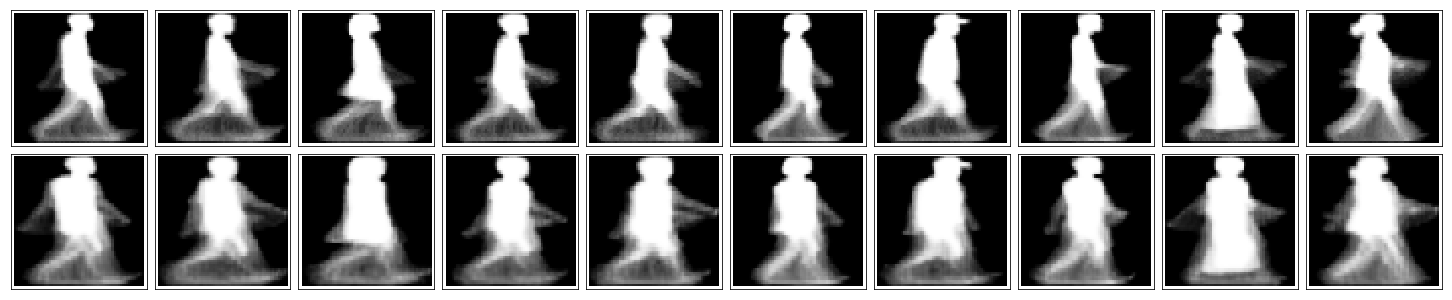

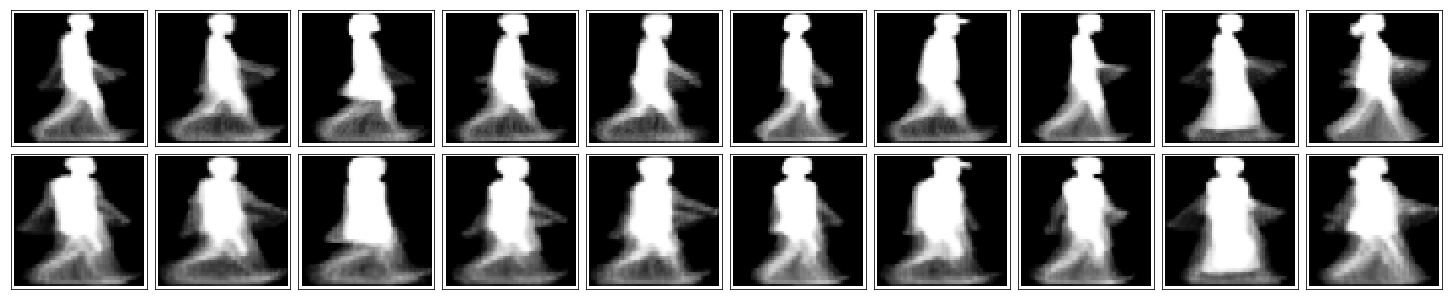

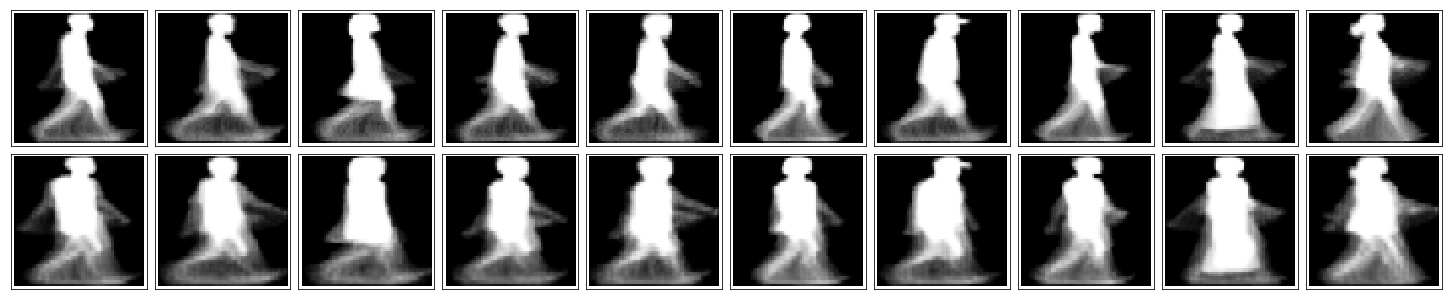

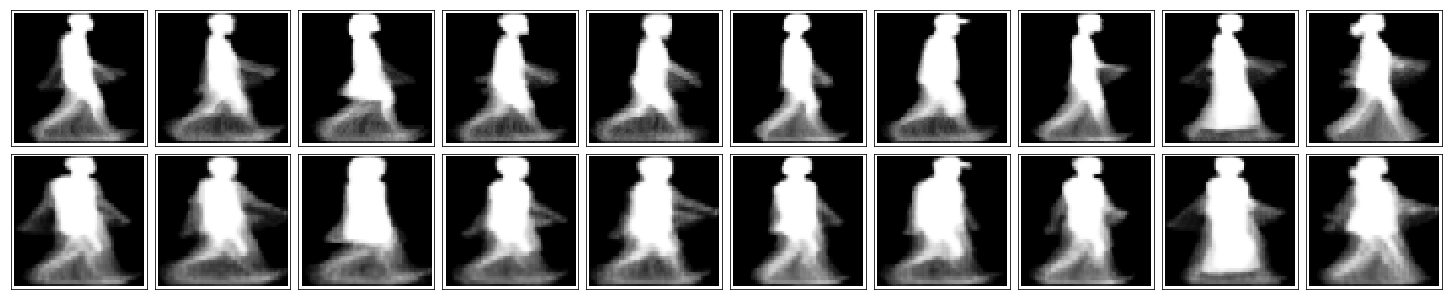

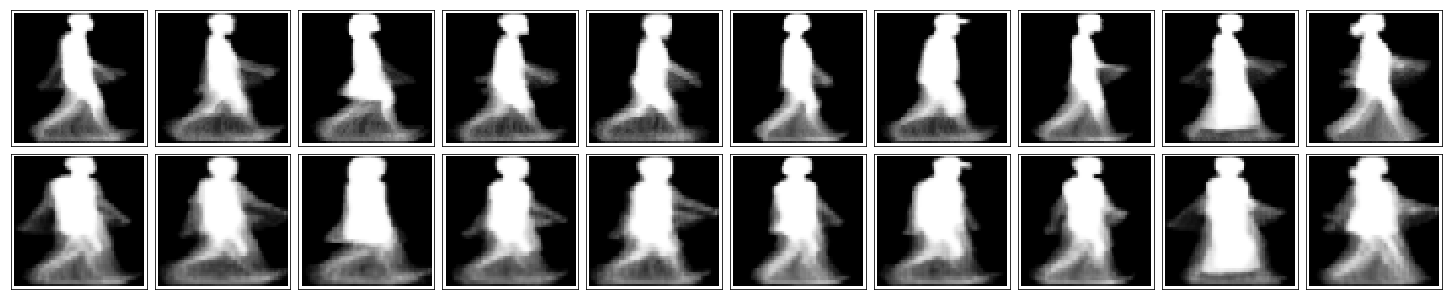

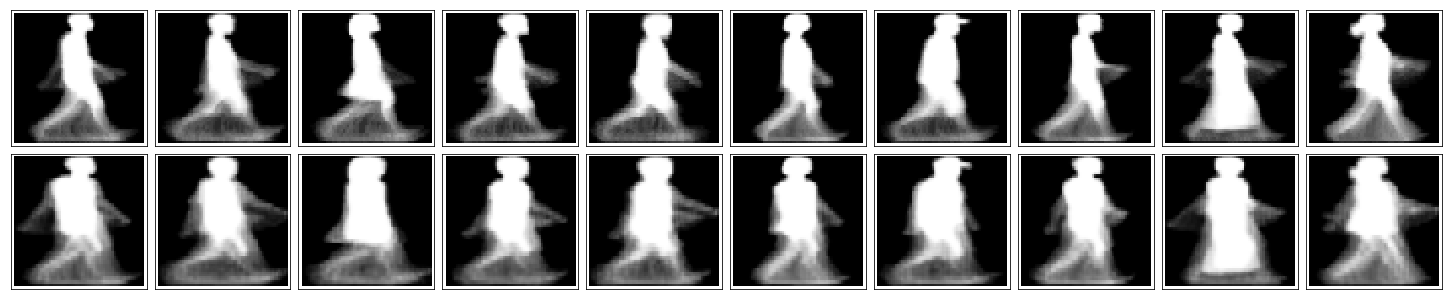

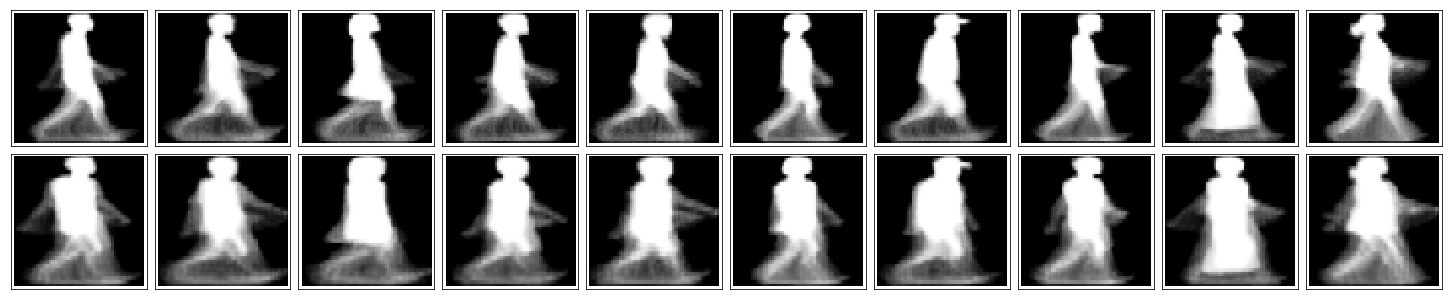

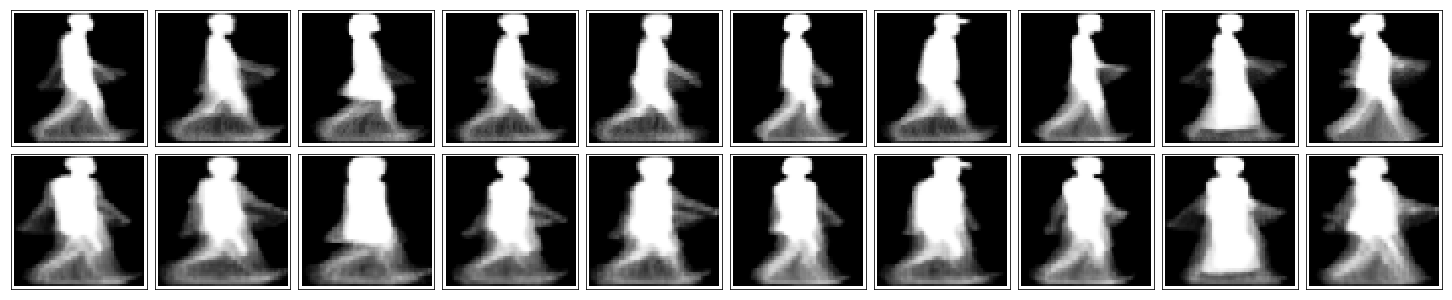

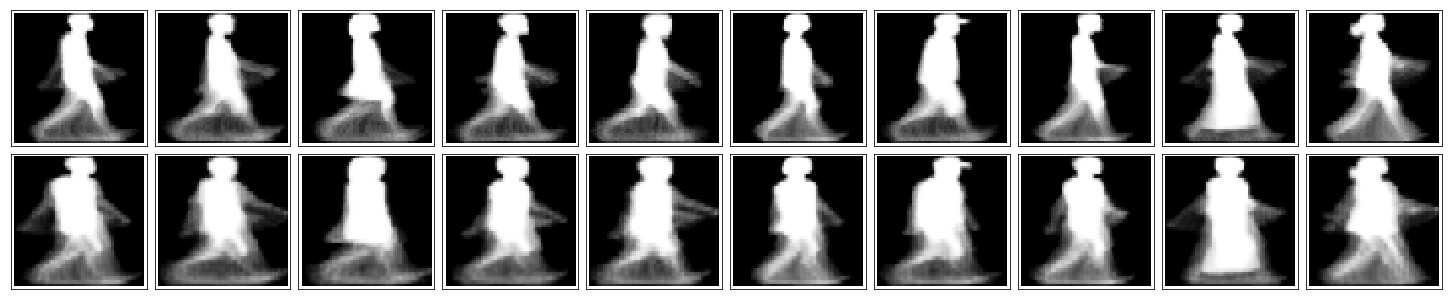

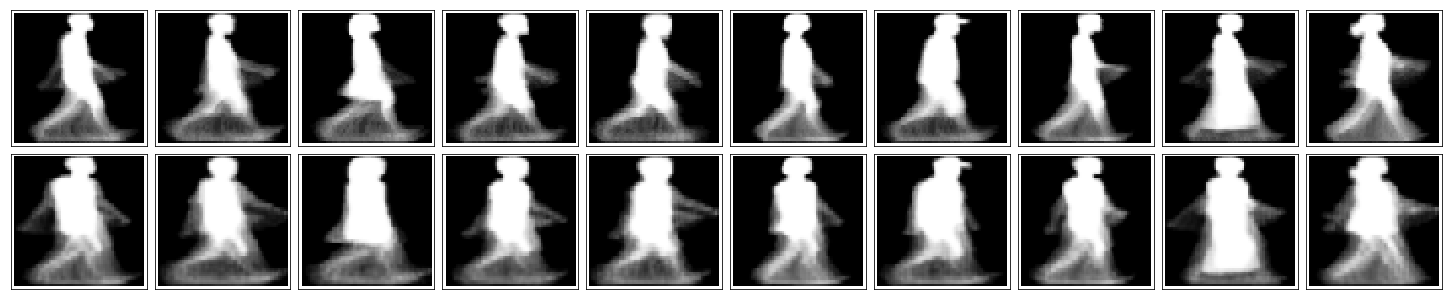

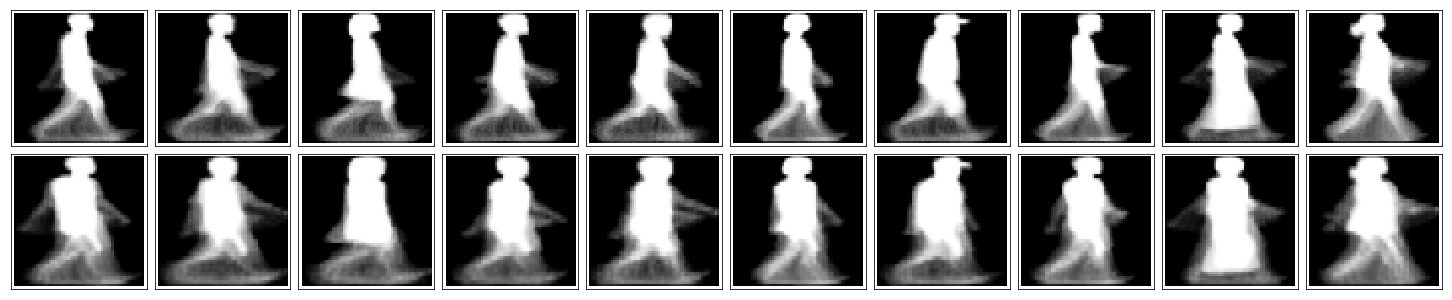

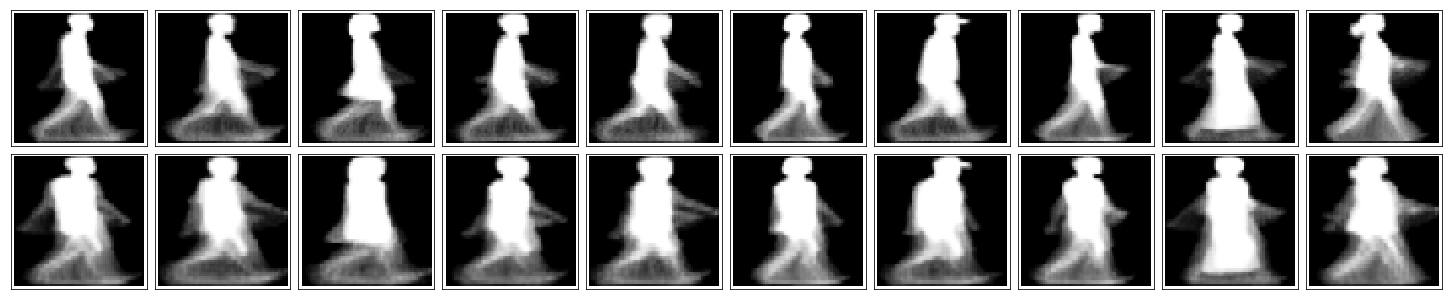

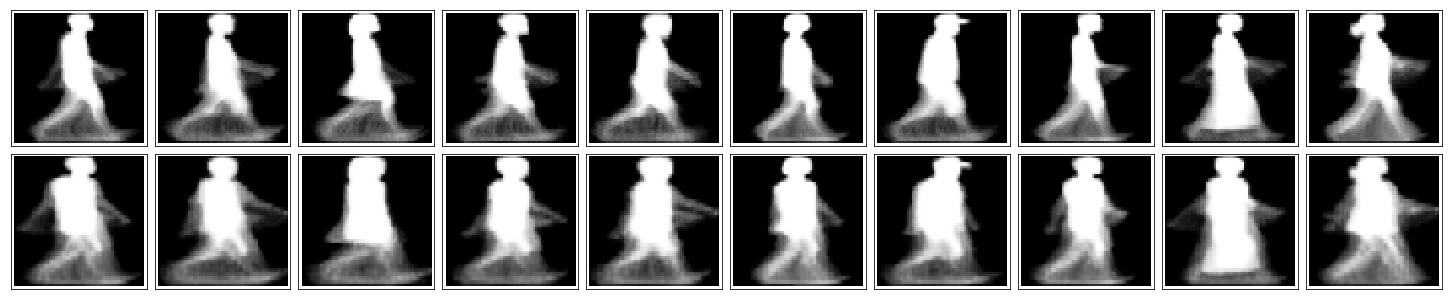

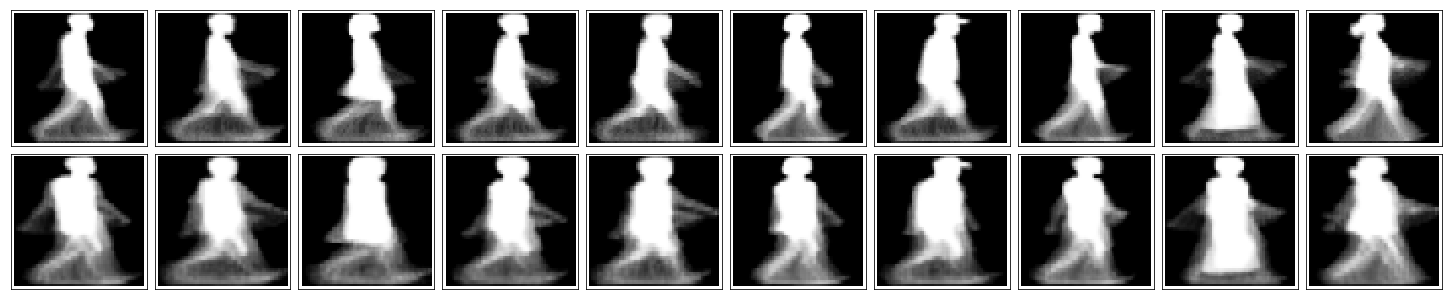

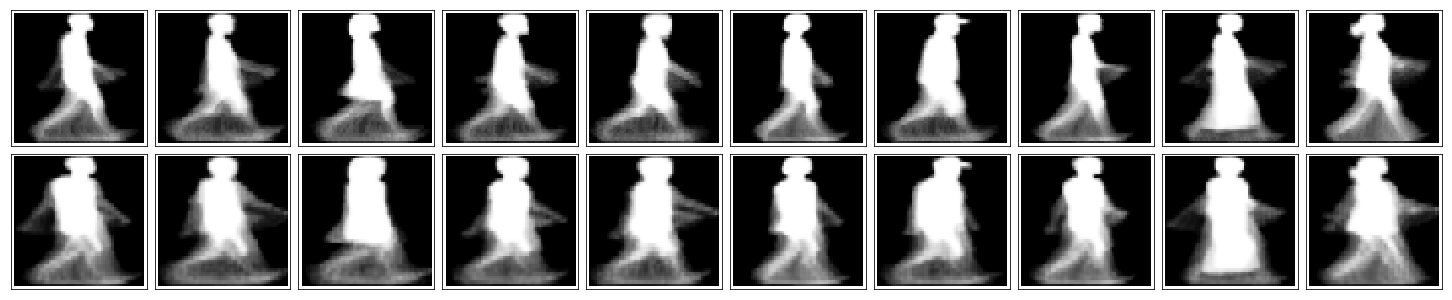

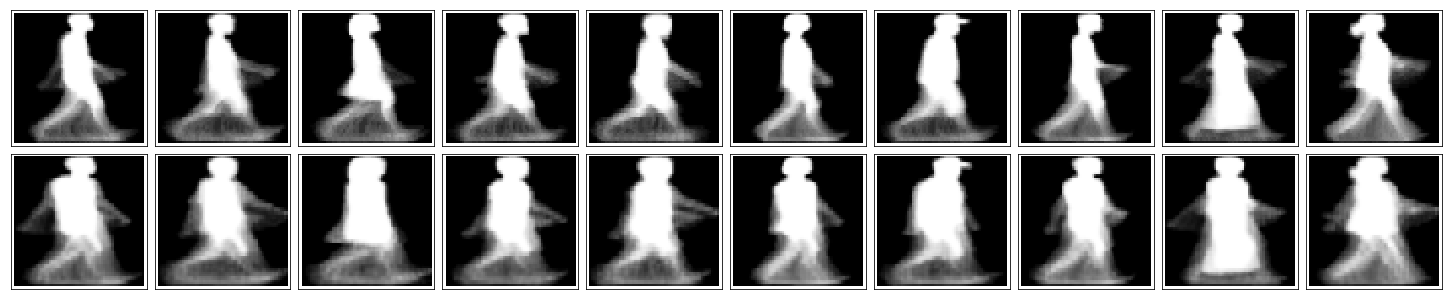

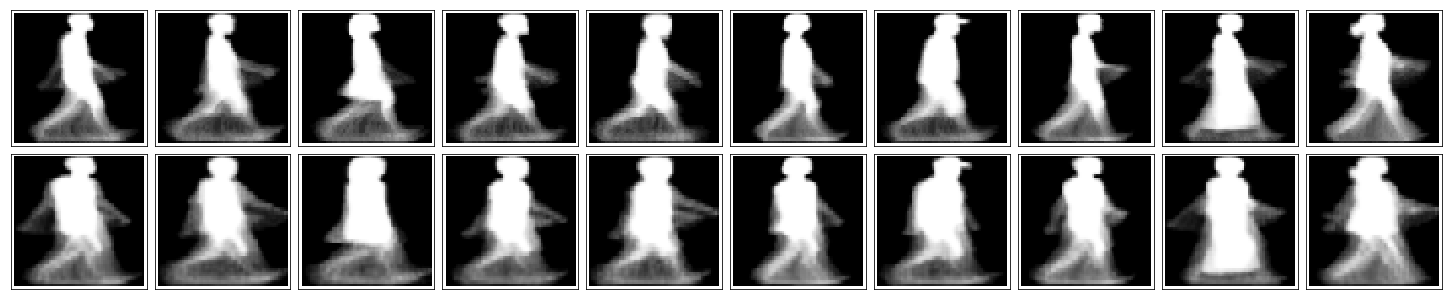

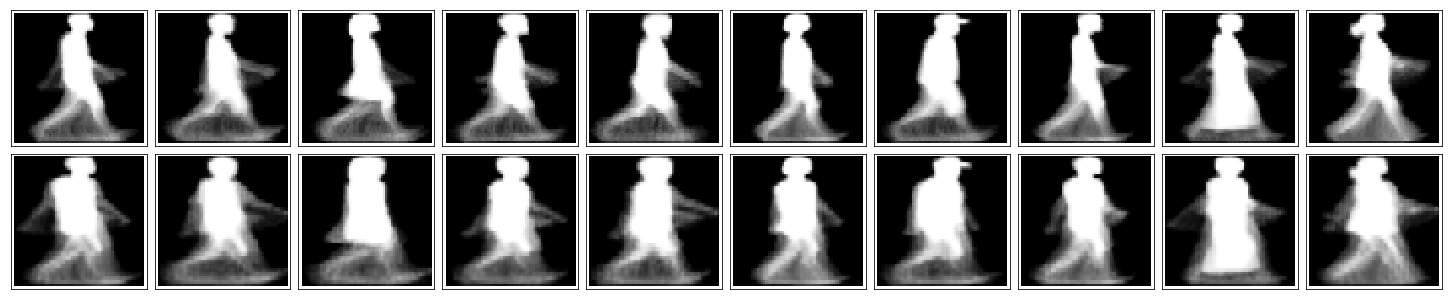

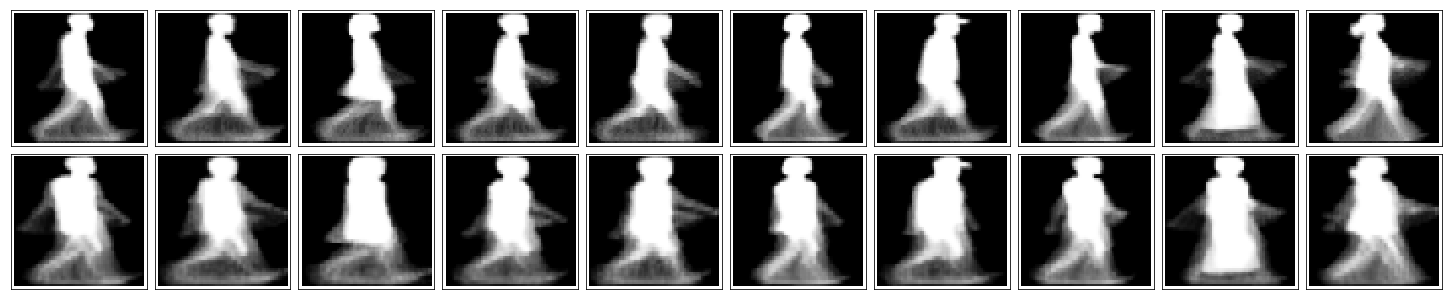

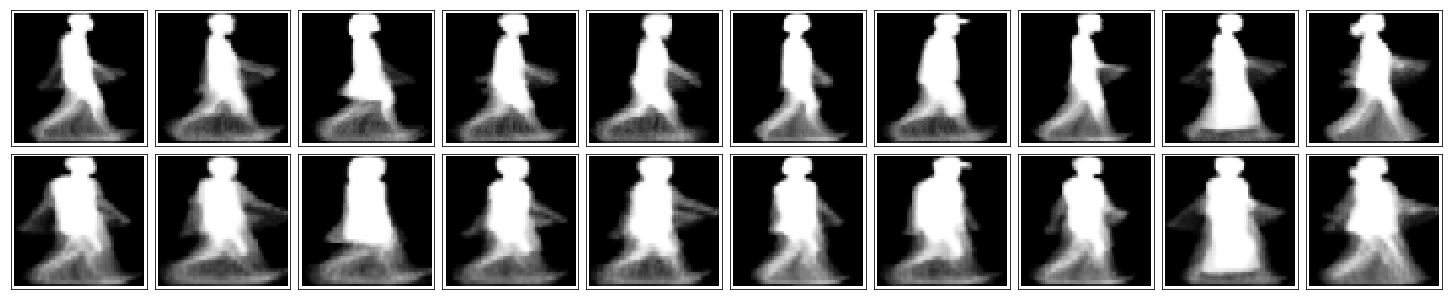

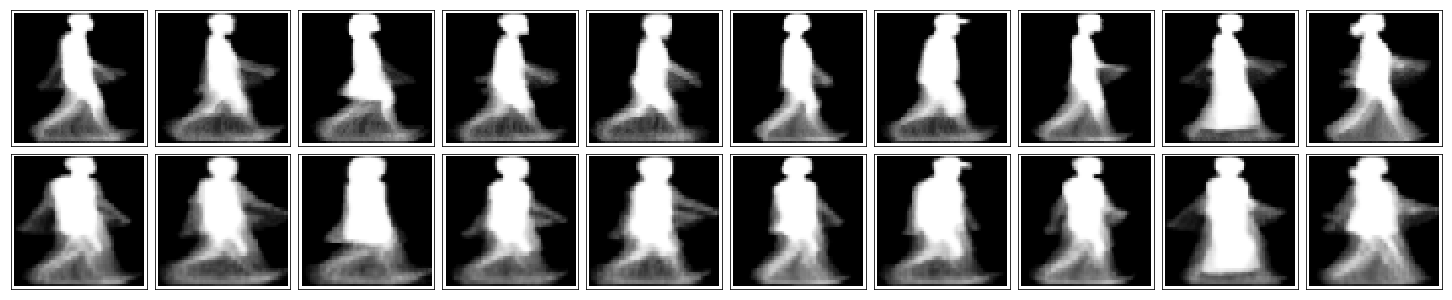

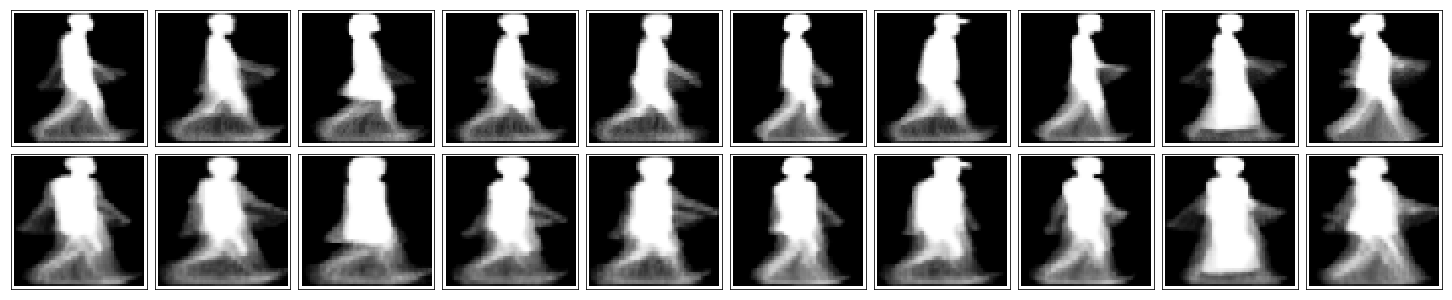

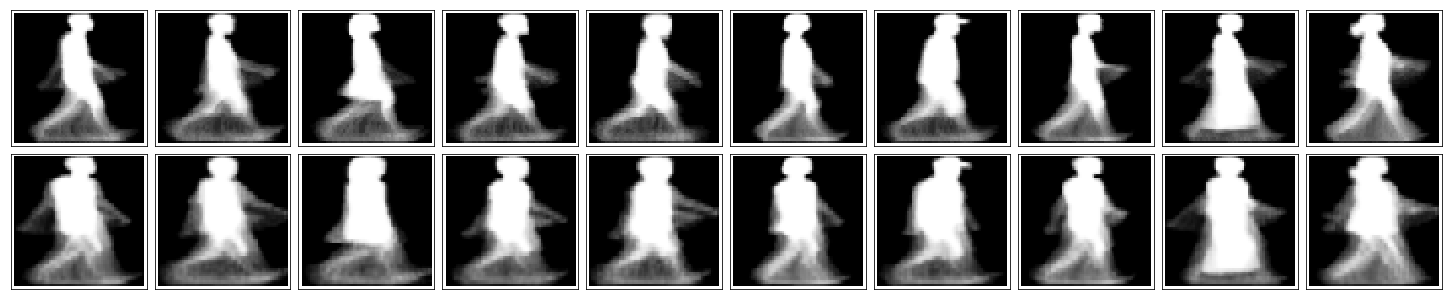

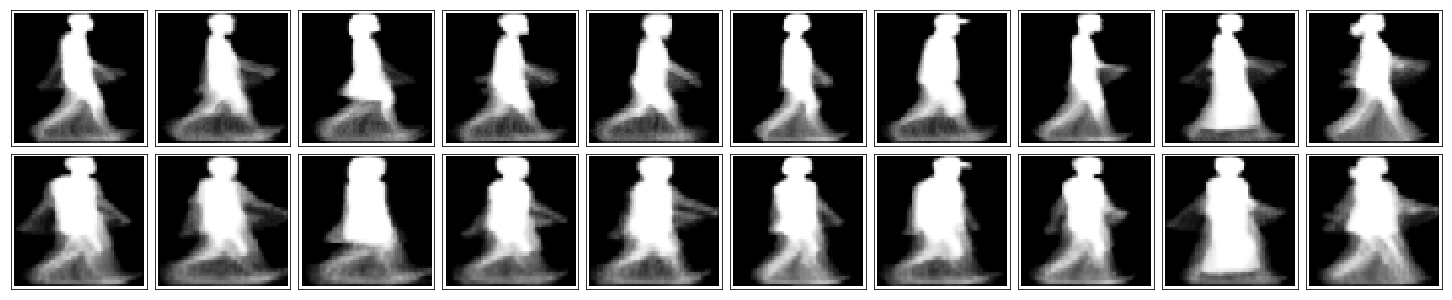

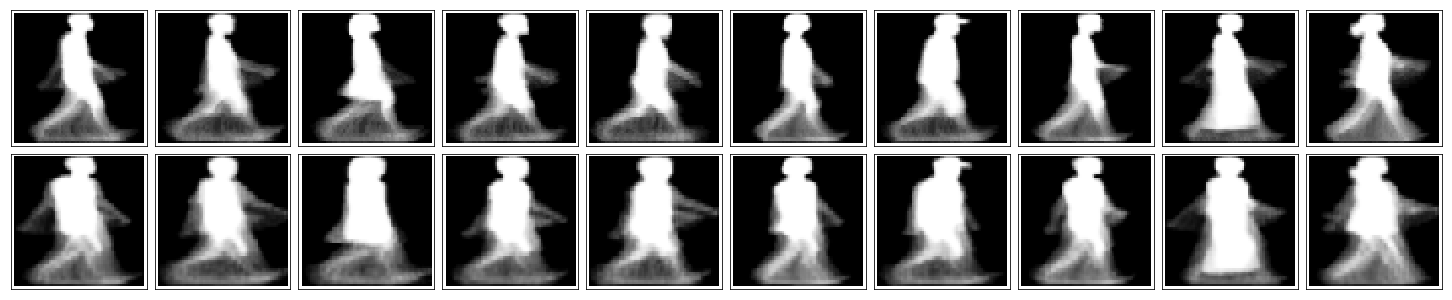

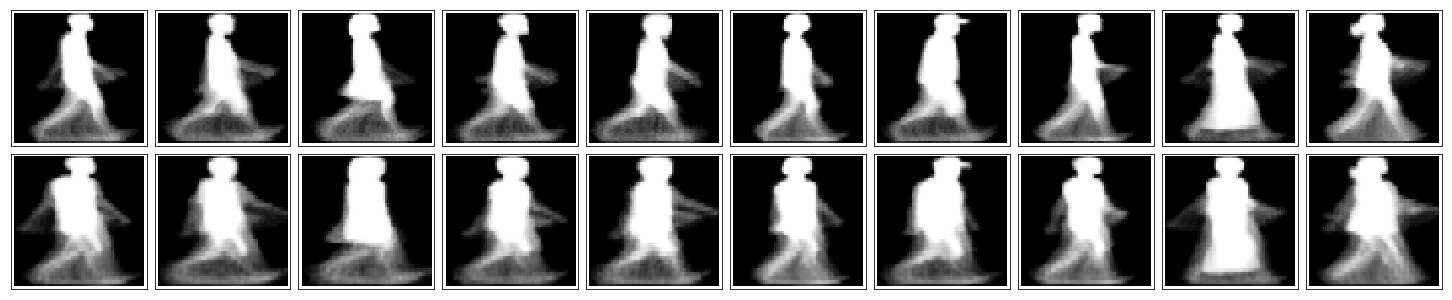

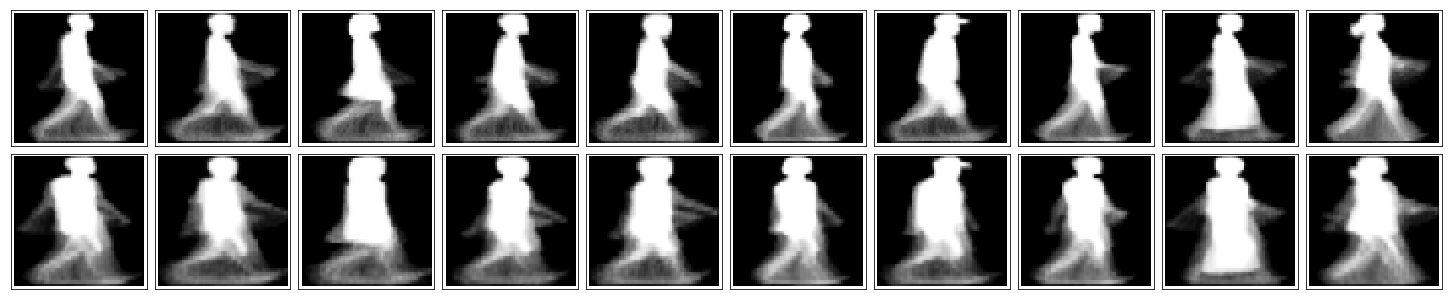

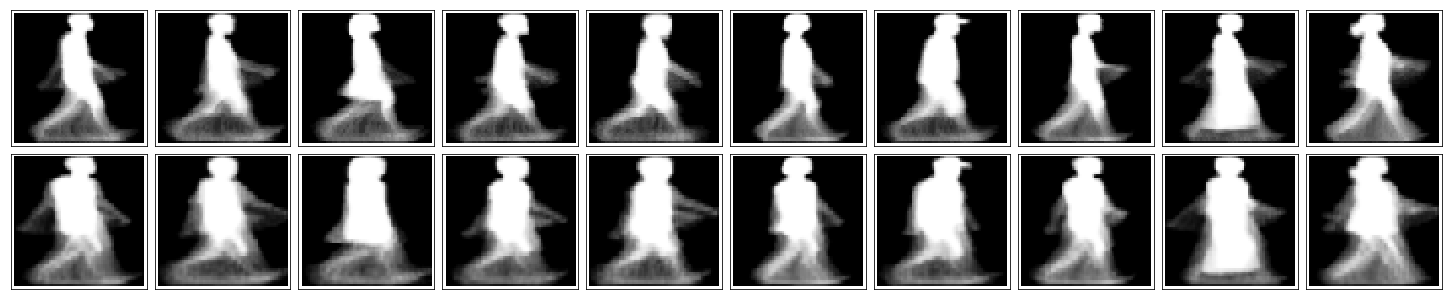

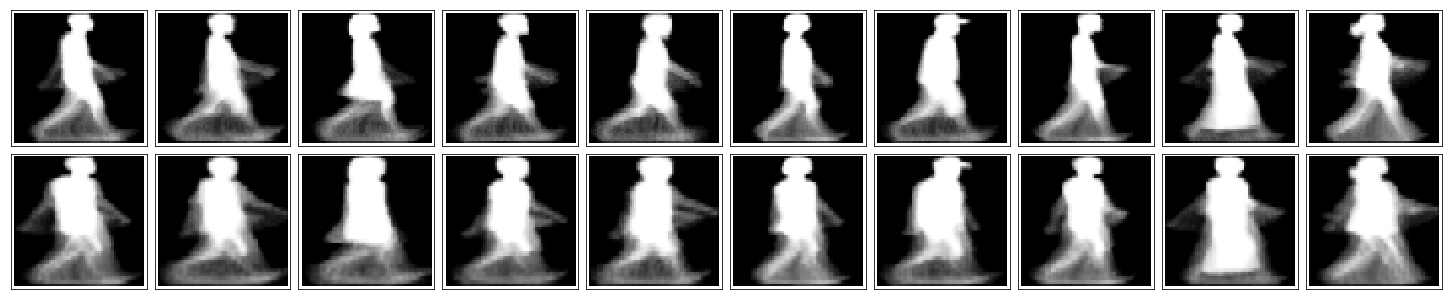

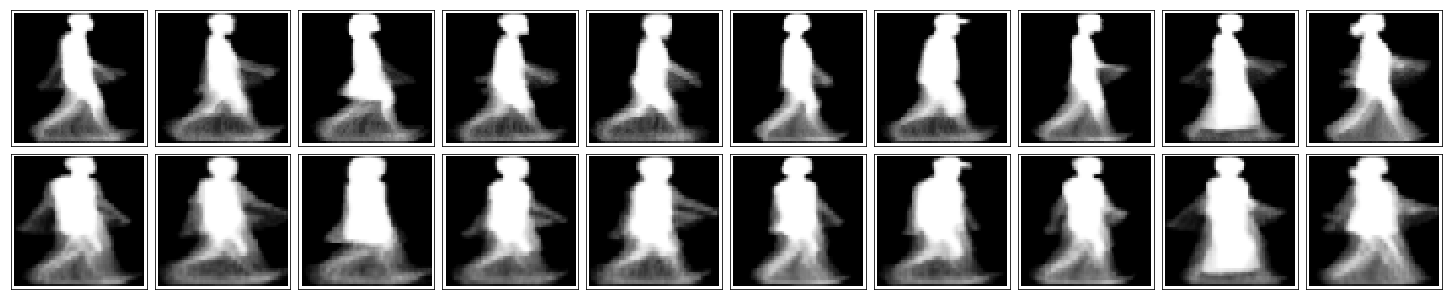

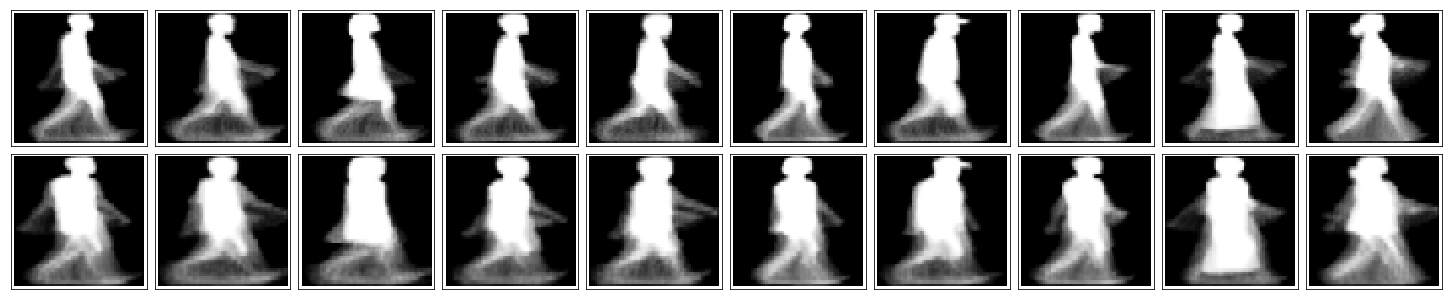

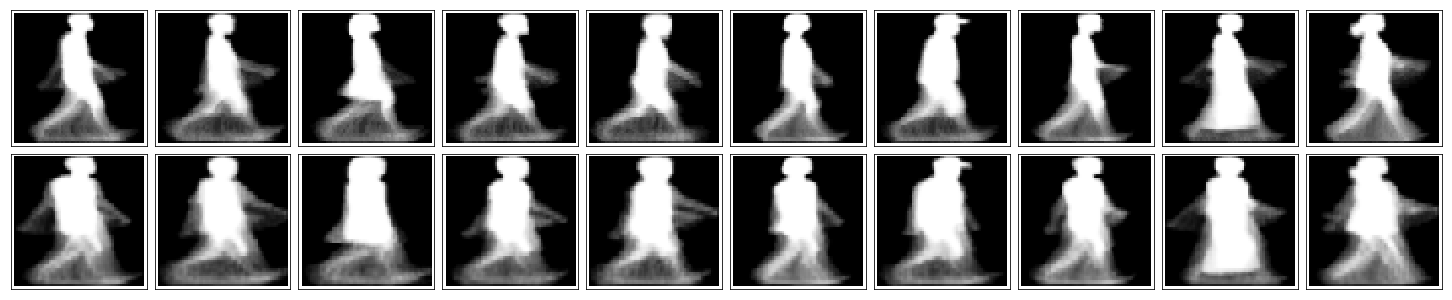

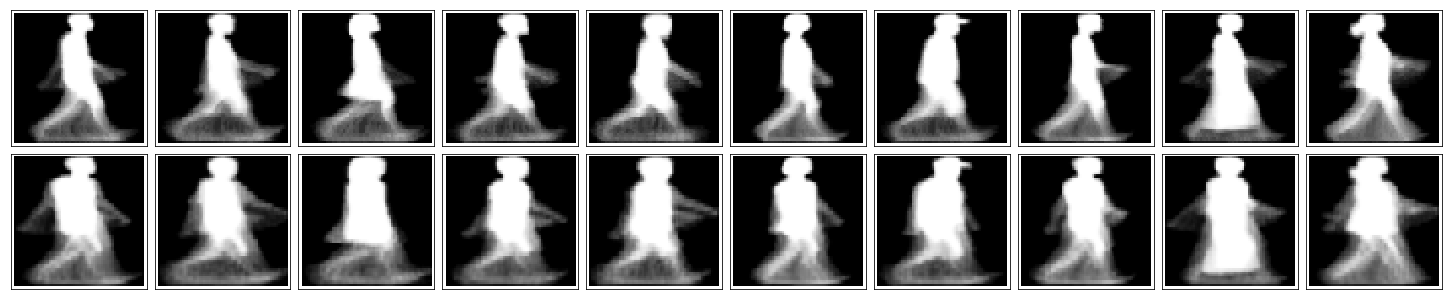

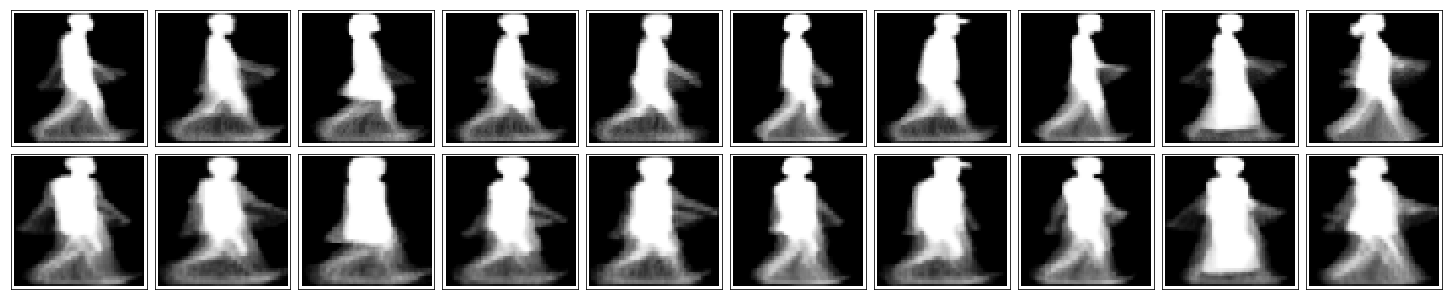

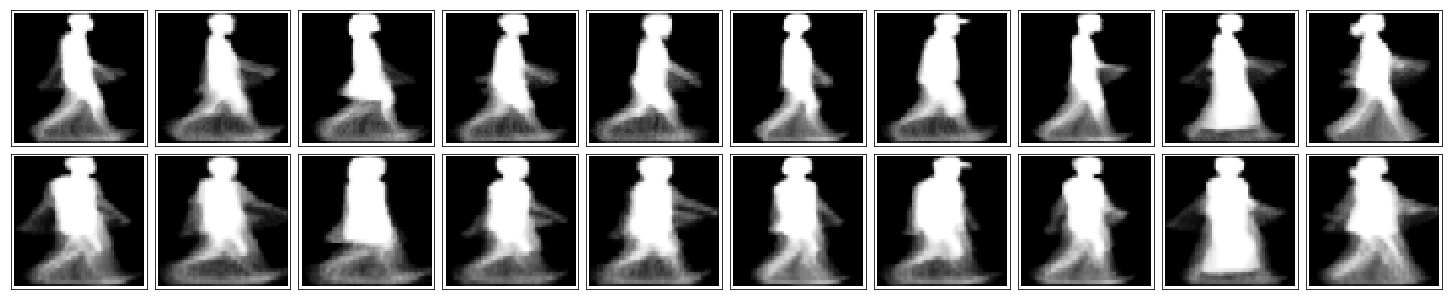

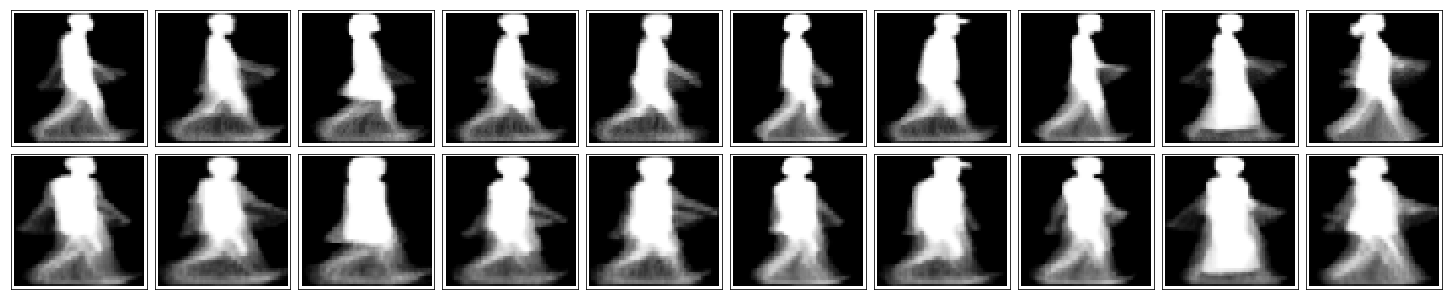

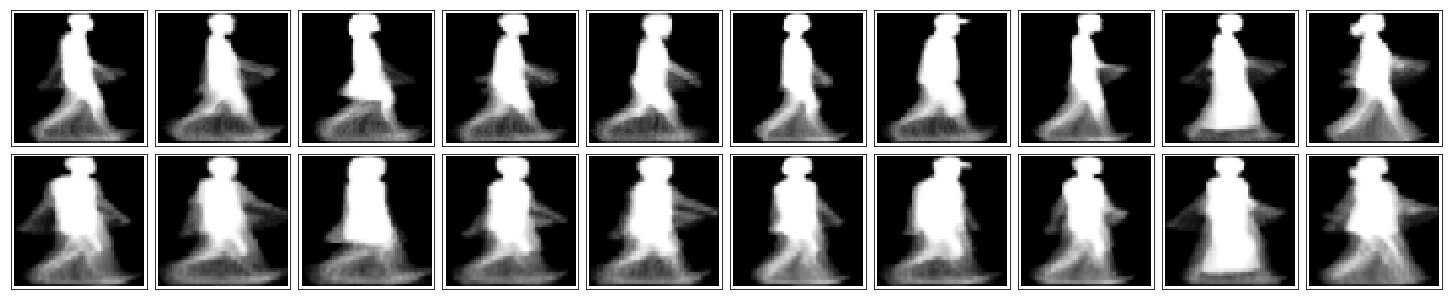

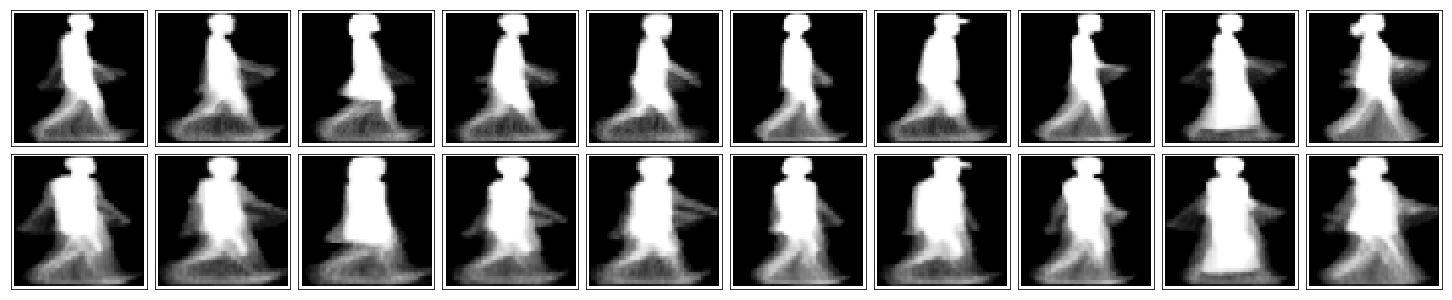

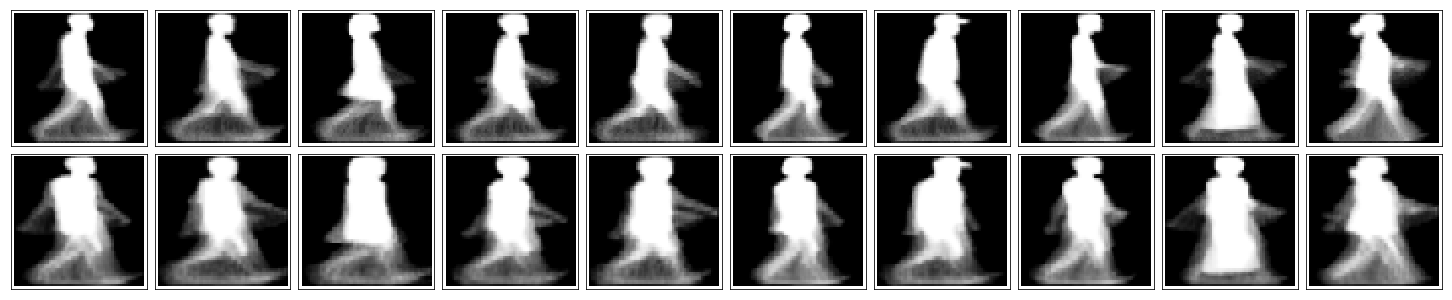

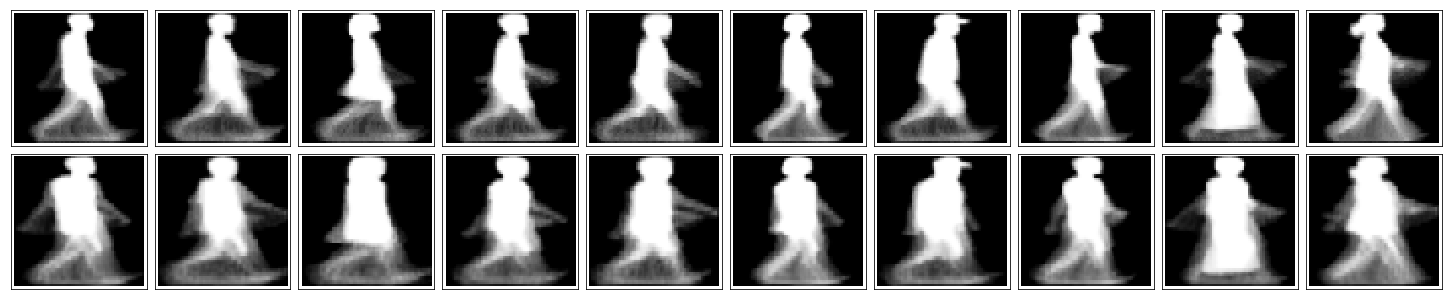

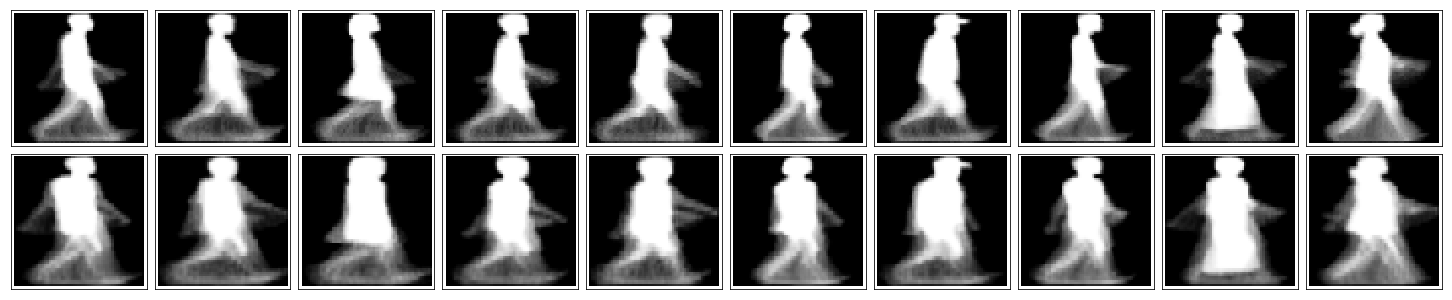

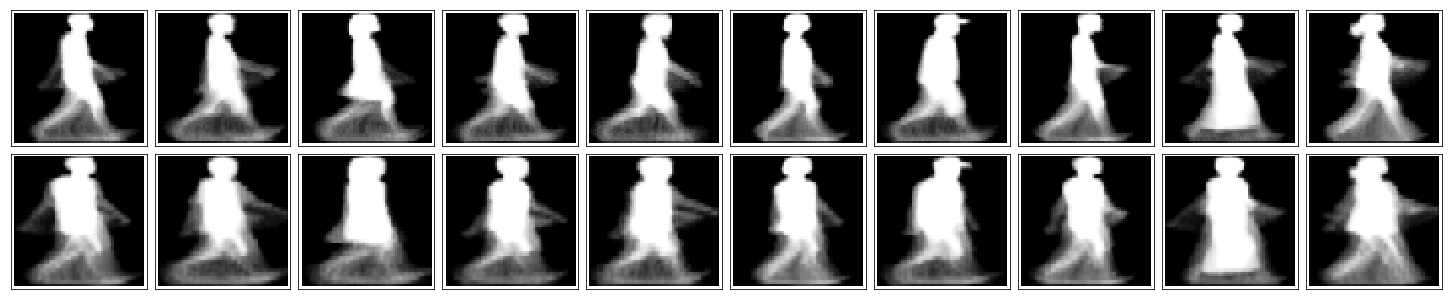

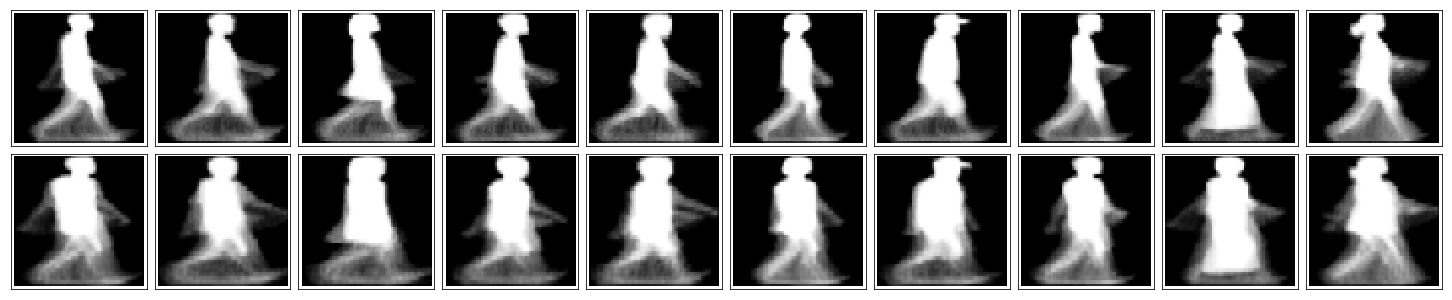

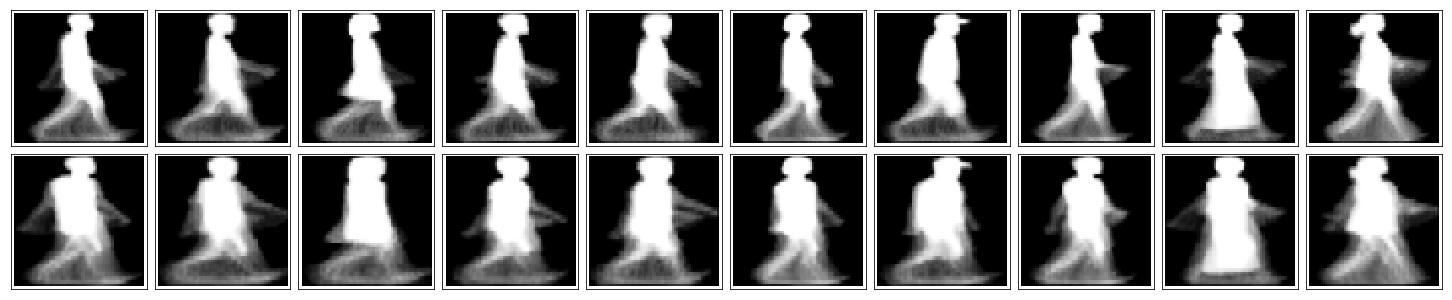

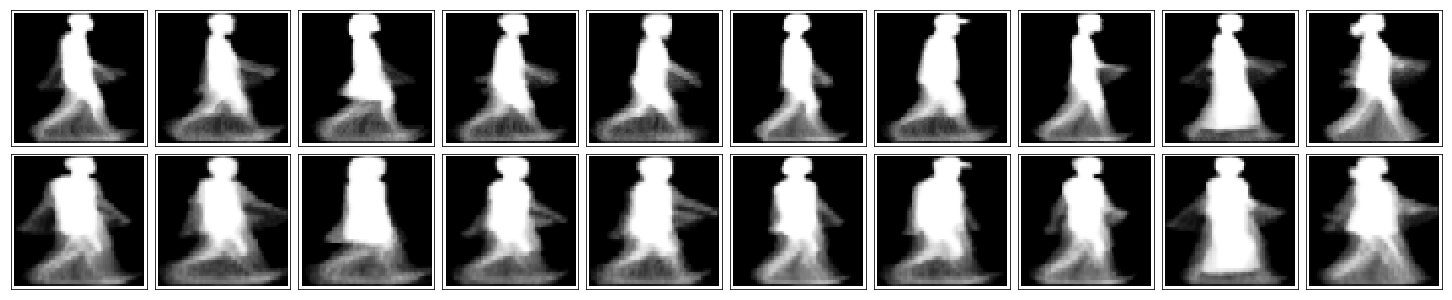

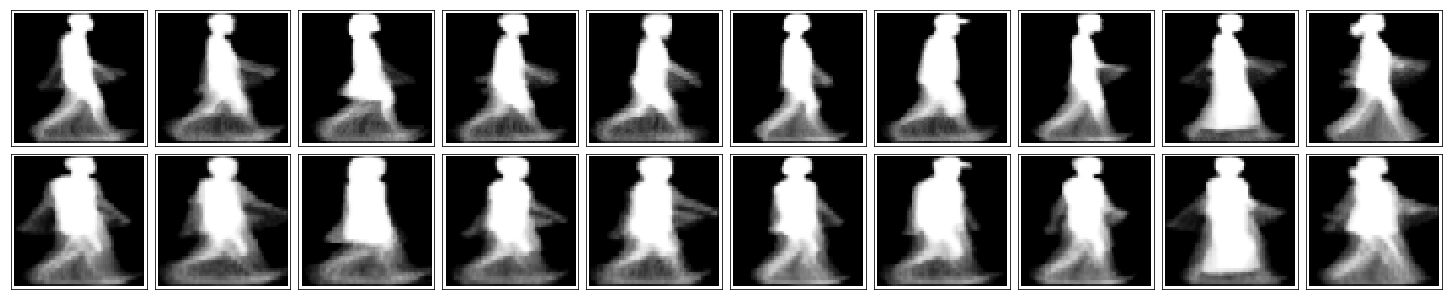

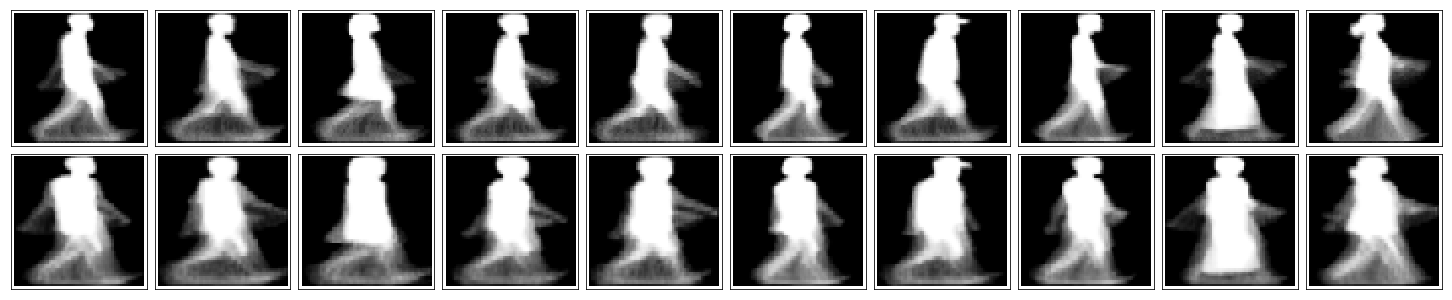

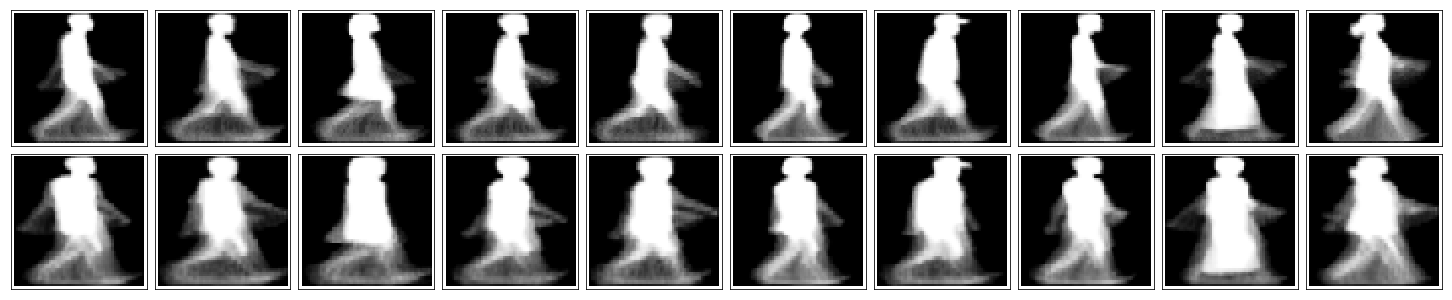

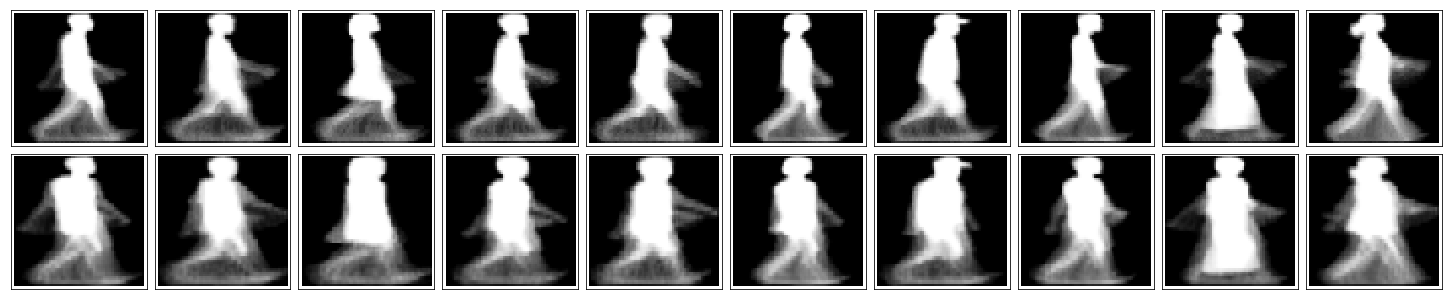

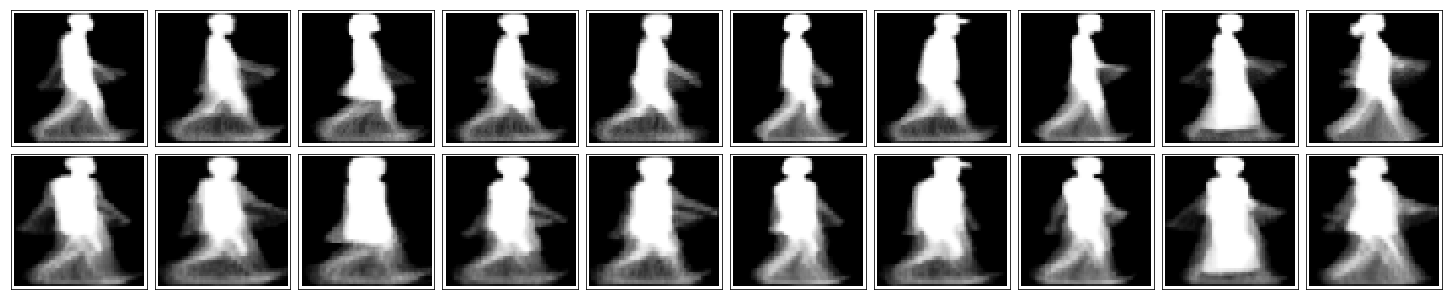

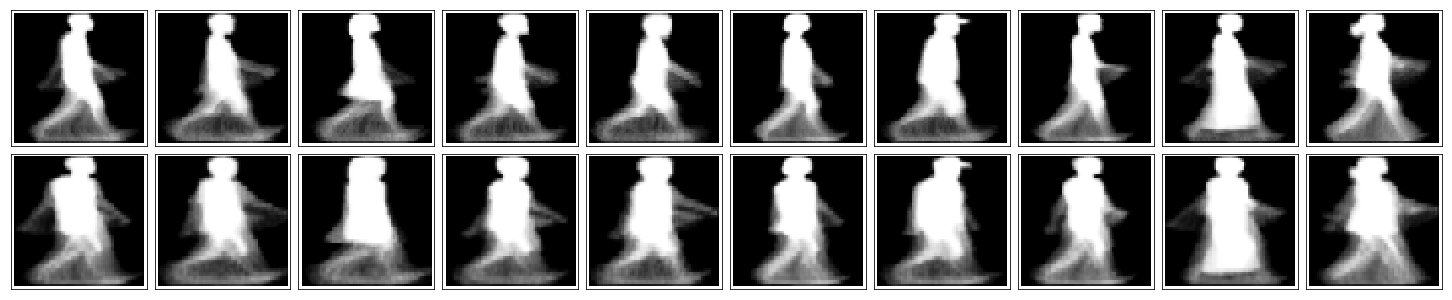

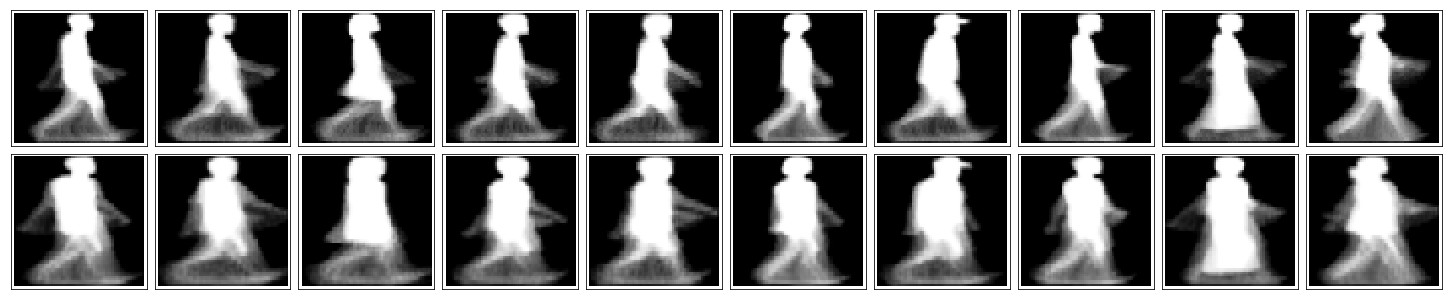

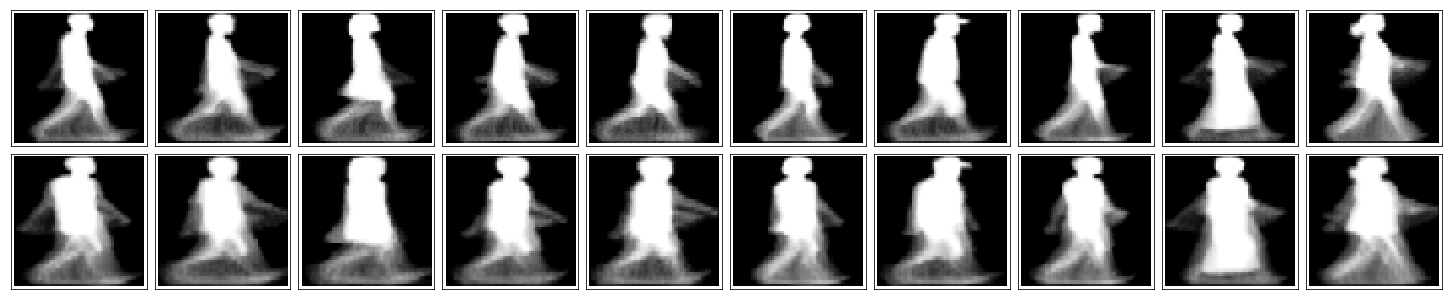

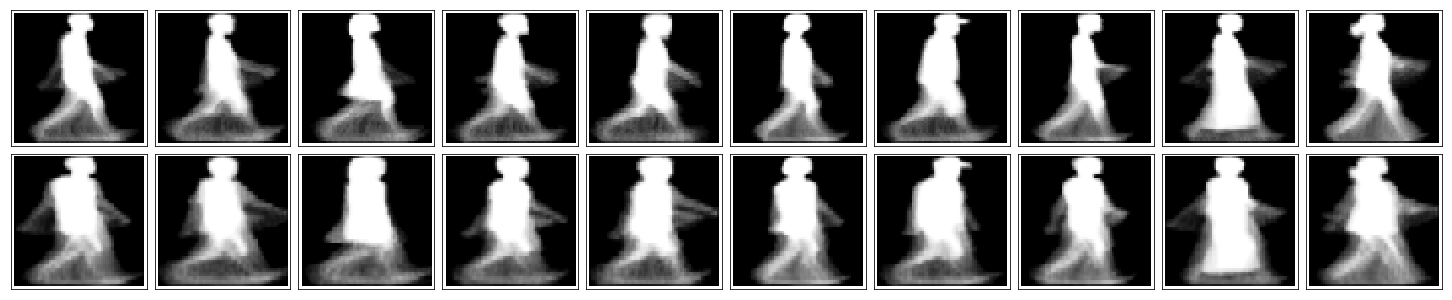

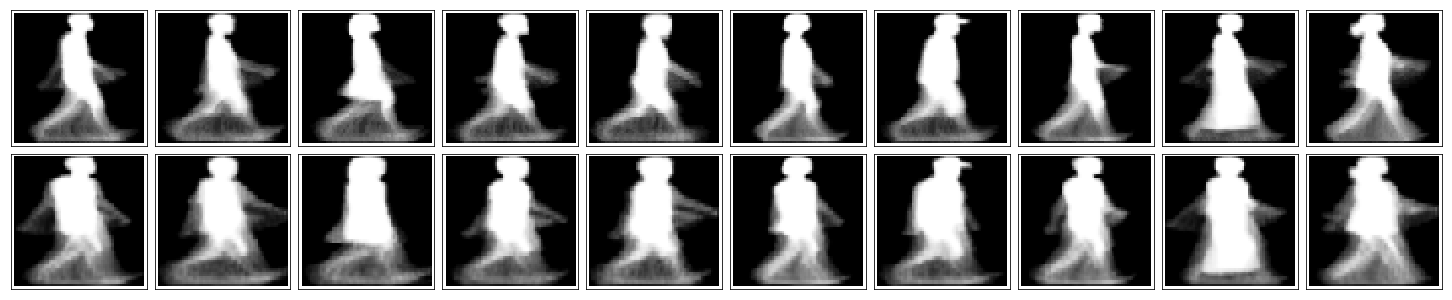

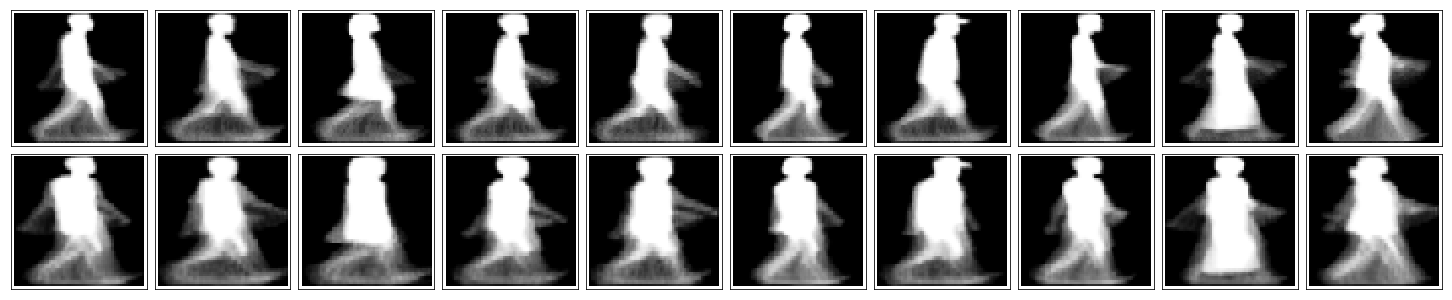

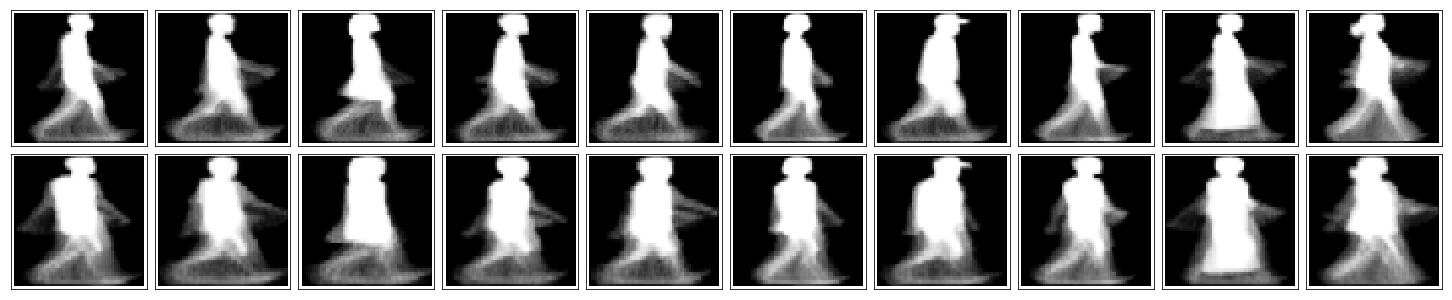

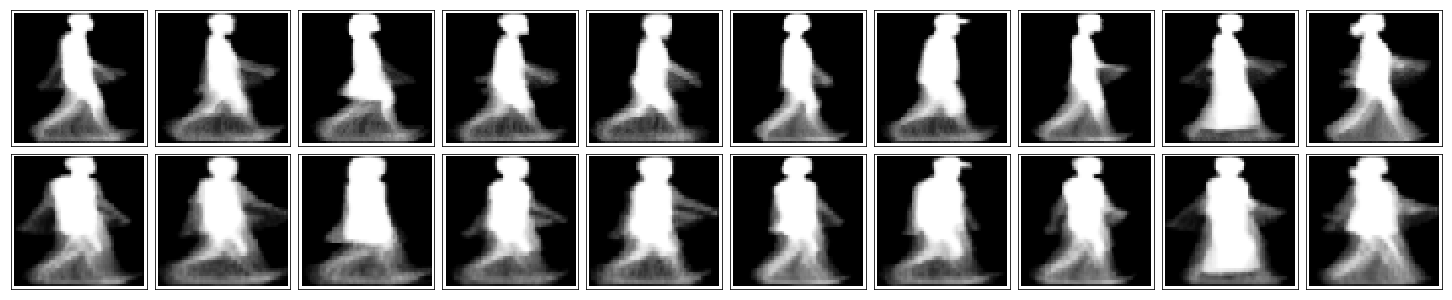

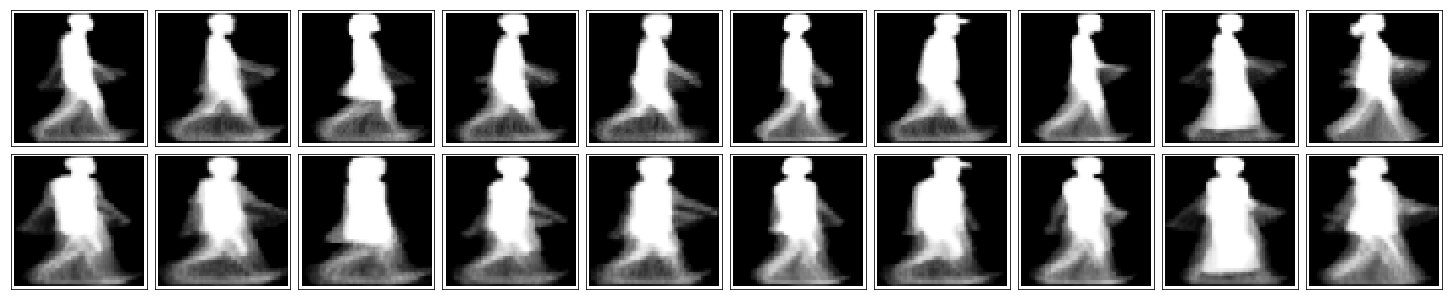

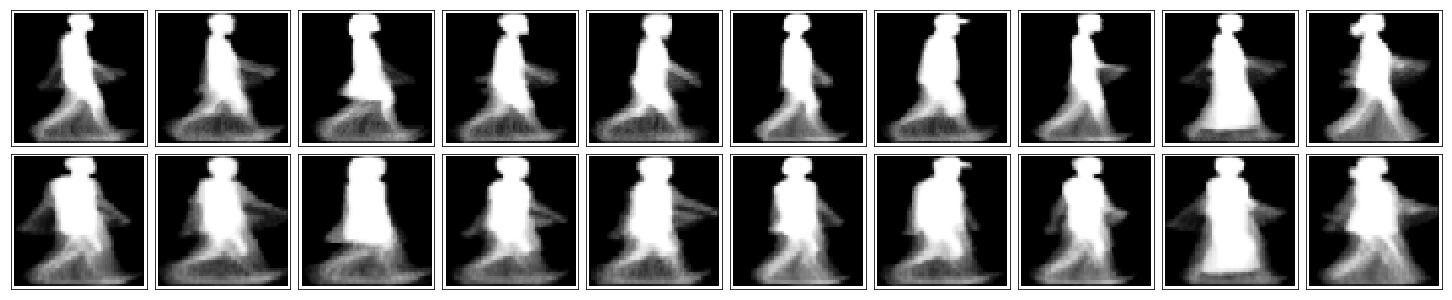

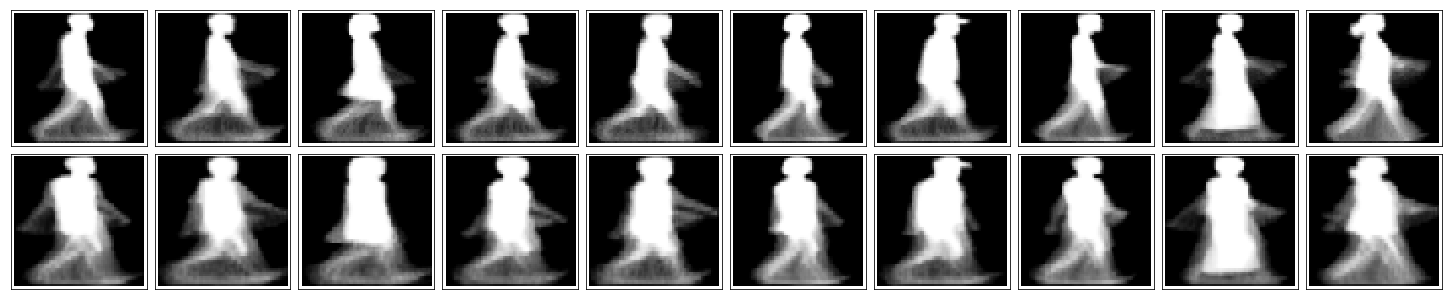

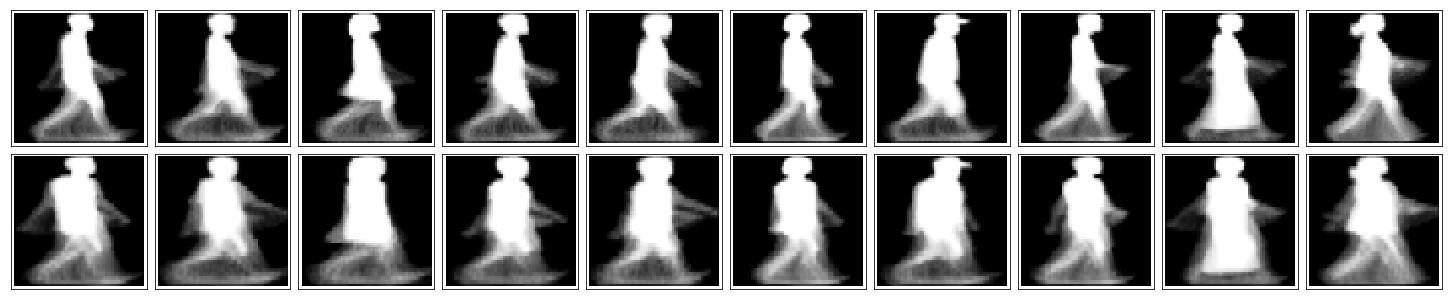

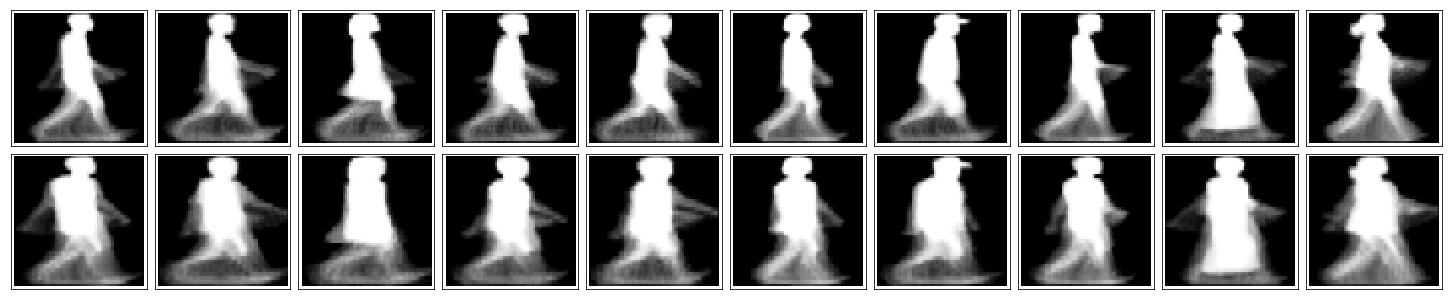

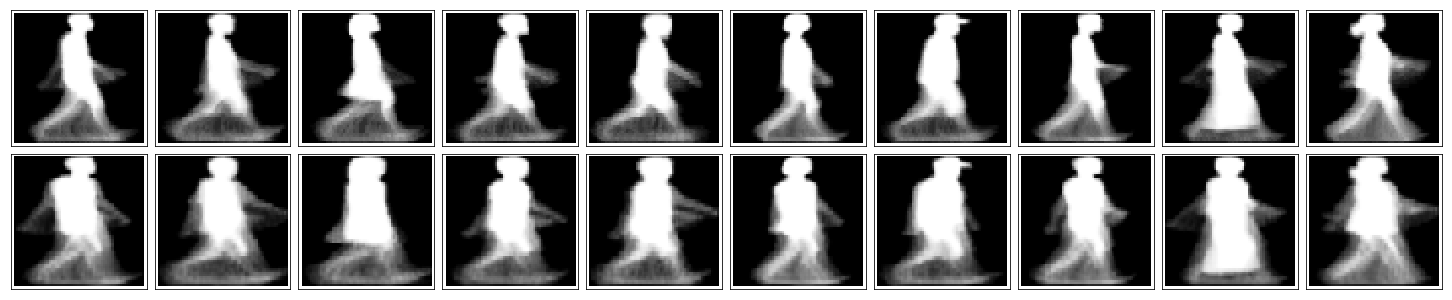

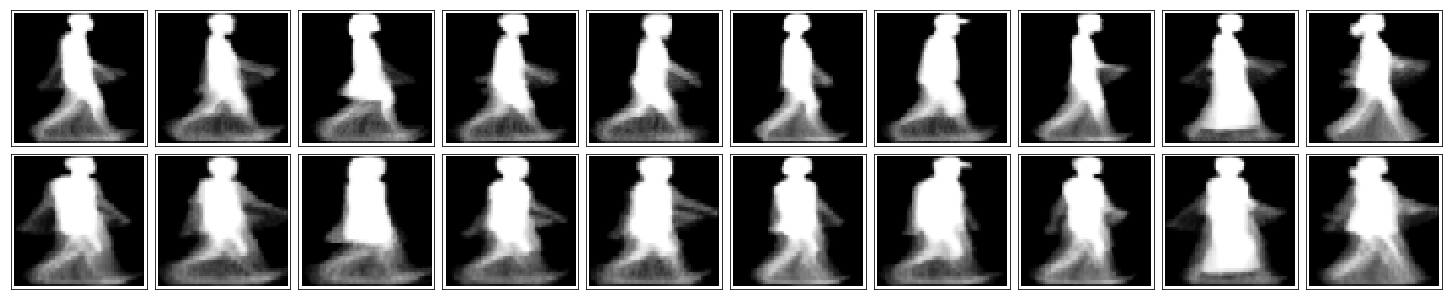

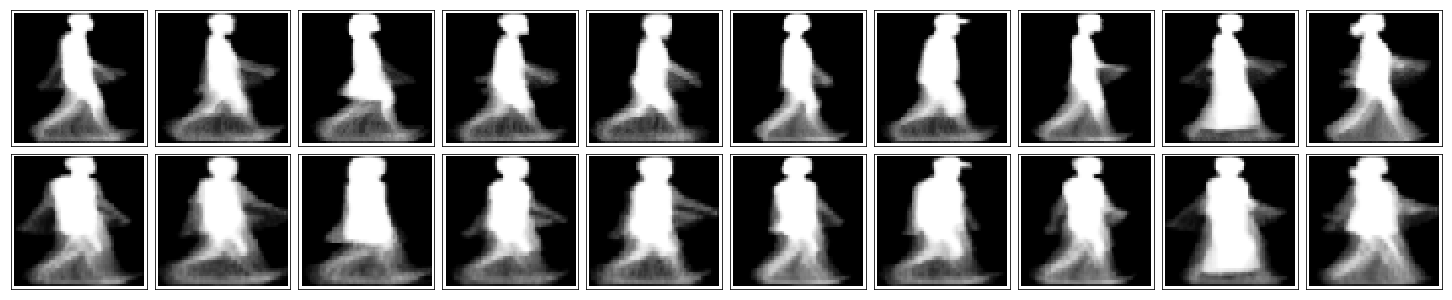

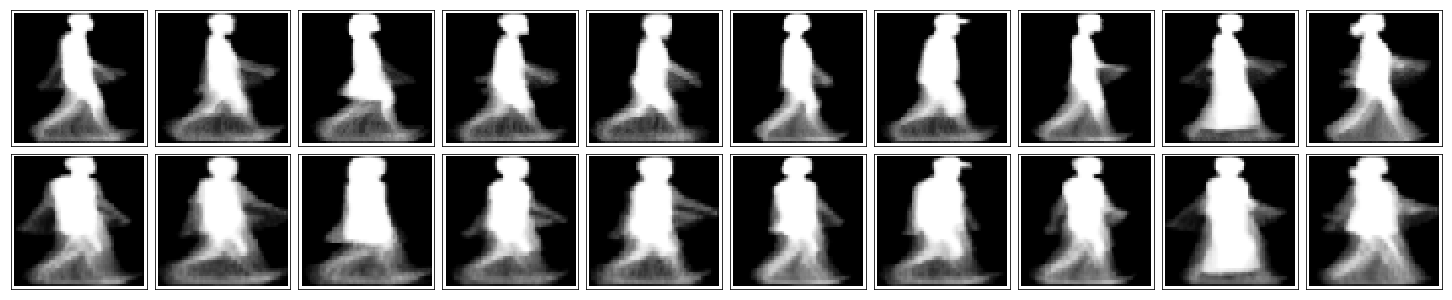

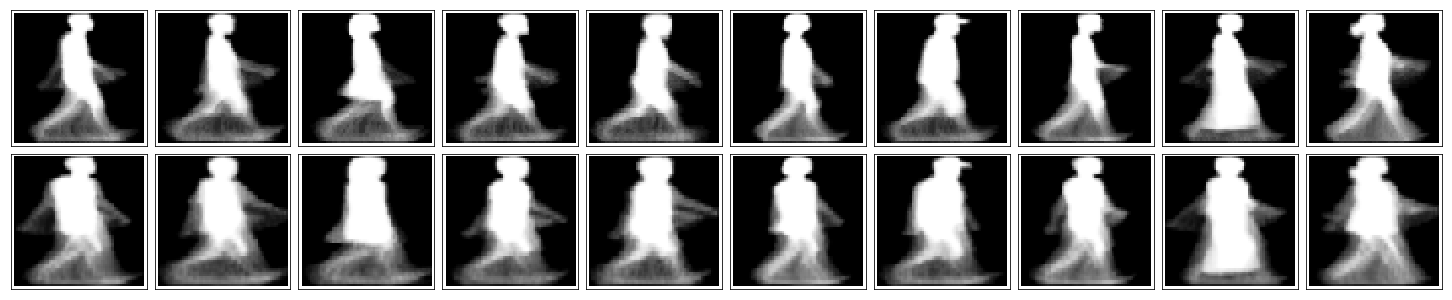

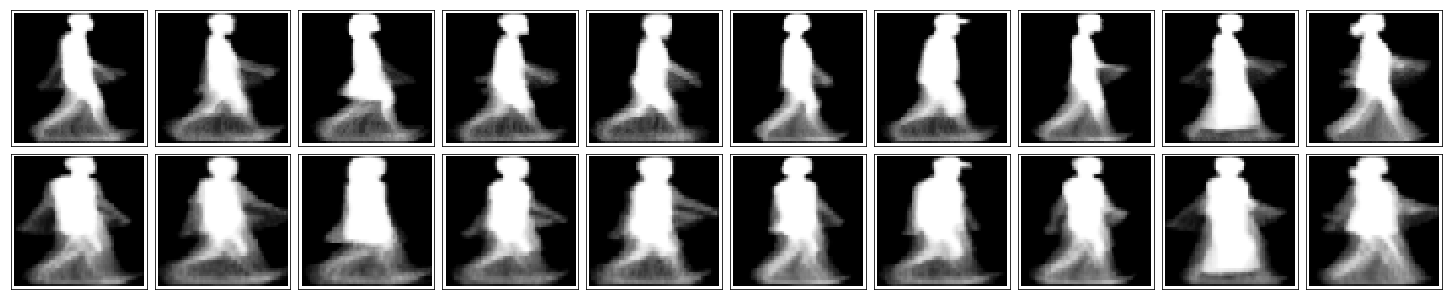

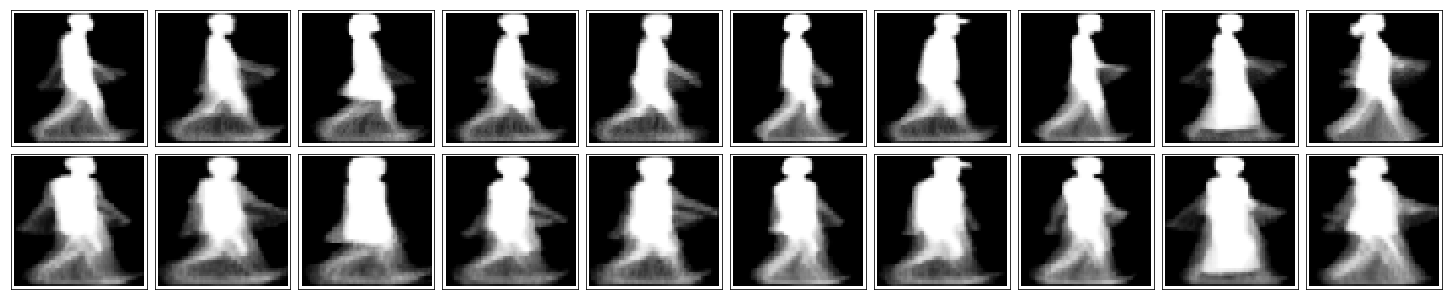

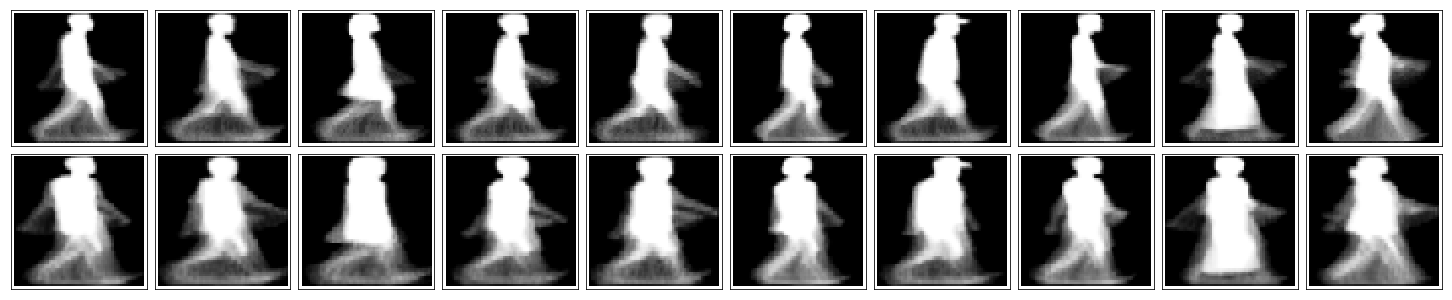

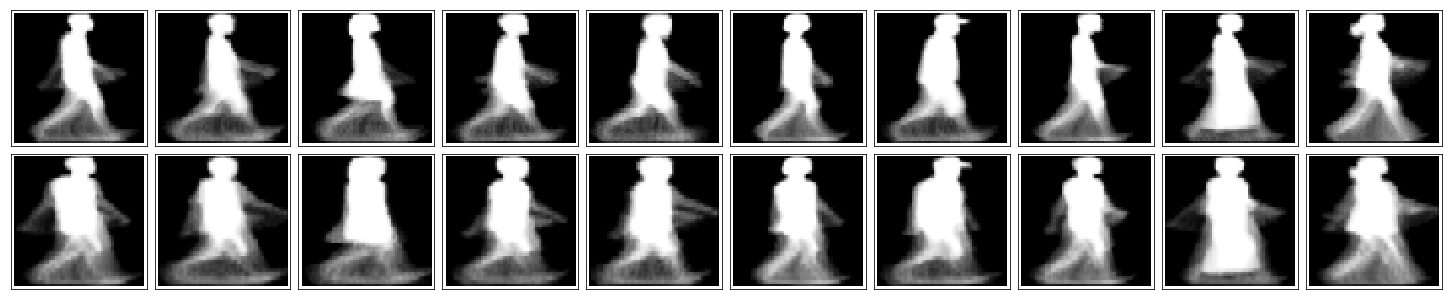

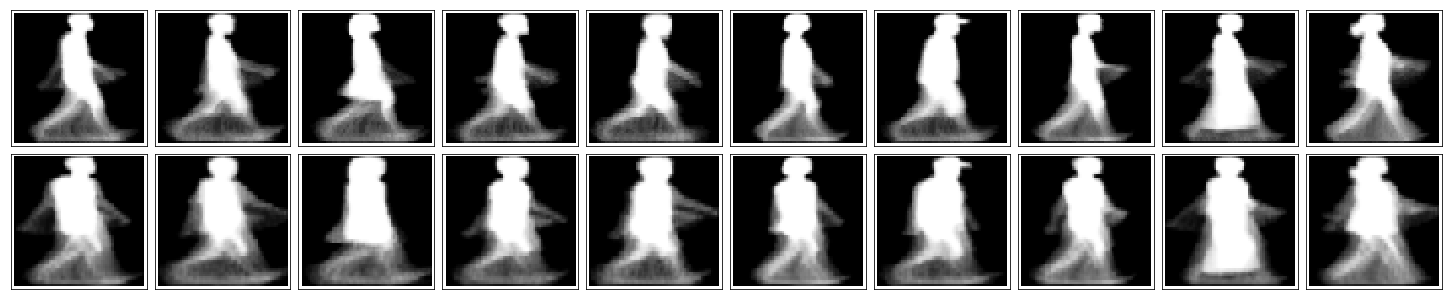

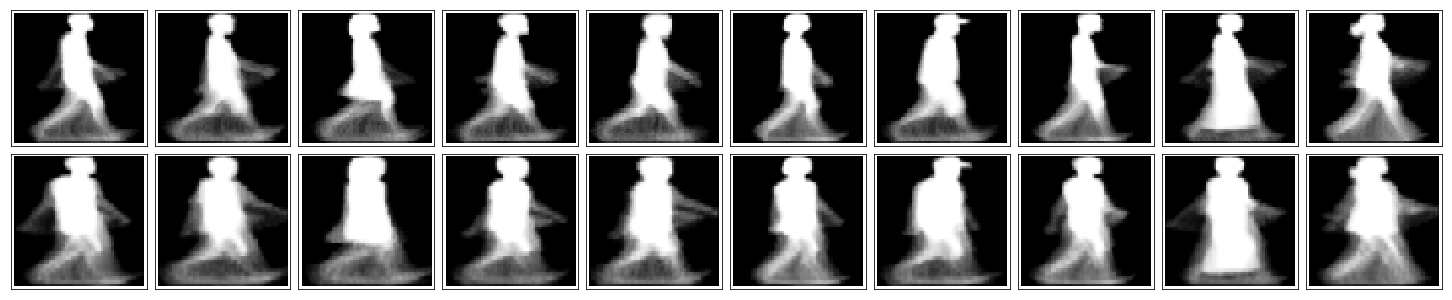

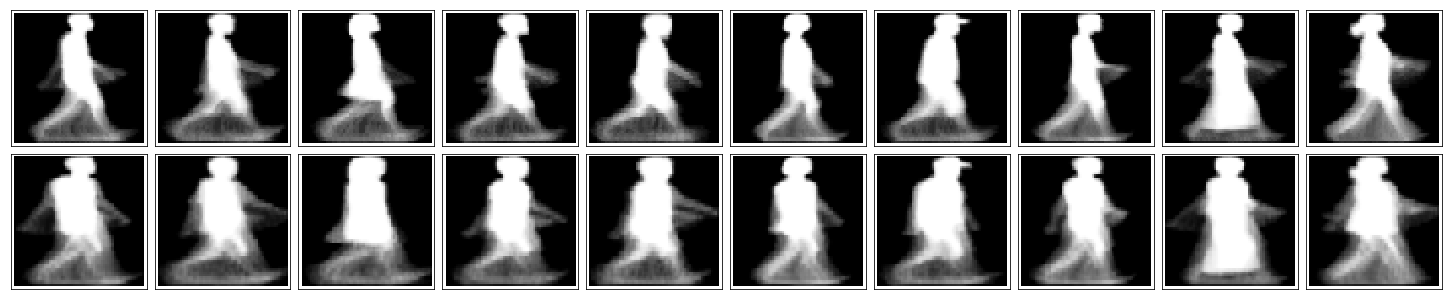

In [29]:
epochs = 1800
batch_size = 80

for lr in [0.0007]:
    save_string = './checkpoints_view_invariant/E2E_lr={}_bs={}.ckpt'.format(lr, batch_size)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g) as sess:
        sess.run(tf.global_variables_initializer())

        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_decrease_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0


        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):

                start = time.time()

                feed_1 = {
                            inputs: train_batch, 
                            targets: target_batch,
                            keep_p: 0.6,
                            learning_rate: lr,
                            training:True
                        }

                train_loss, _, decoded_img = sess.run([cost, opt, decoded], feed_dict=feed_1)

                train_acc = cal_accuracy(decoded_img, target_batch)

                if iteration%25==0:
                    end = time.time()
                    print("Epoch: {}/{},".format(e+1, epochs),' '
                              "Iteration: {},".format(iteration),' '
                              "Train loss: {:.3f},".format(train_loss),'      '
                              "{:.1f}s /batch.".format((end-start)/5),' '
                              "Train Accuracy: %{:.3f}".format(train_acc))

                    ##############################################################
                    ######################## VALIDATION ##########################
                    ##############################################################

                if iteration%75==0:
                    validation_loss = []
                    validation_acc = []

                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size


                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
                        feed_2 = {
                                    inputs: val_batch,
                                    targets: val_target_batch,
                                    keep_p: 1,
                                    training:True
                                }

                        val_loss, val_decoded_img = sess.run([cost, decoded], feed_dict=feed_2)

                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)

                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)

                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))

                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss),' '
                              "Validation accuracy: {:.3f},".format(mean_val_acc))
                    print()
                ####### plot #######
                if iteration%500==0:

                    feed_3 = {
                                inputs: val_x[:10],
                                keep_p: 1,
                                training:True
                                }

                    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
                    in_imgs = val_y[:10]
                    reconstructed = sess.run(decoded, feed_dict=feed_3)

                    # plot out
                    for images, row in zip([in_imgs, reconstructed], axes):
                        for img, ax in zip(images, row):
                            ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)


                    fig.tight_layout(pad=0.1)

                iteration += 1

    #             # Early stopping  
    #             if mean_val_Acc - Last_val_Acc <= -0.3:
    #                 count_Acc_not_increase_epochs += 1
    #             if Last_val_loss - mean_val_loss <= -0.01:
    #                 count_loss_not_decrease_epochs += 1

    #             if mean_val_Acc - Last_val_Acc <= -2:
    #                 break
    #             if count_Acc_not_increase_epochs >= 10:
    #                 break
    #             if count_loss_not_decrease_epochs >= 10:
    #                 break

        model.saver.save(sess, r"{}".format(save_string))
        
print(' ')
print(' ')
print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
print(' ')
print(' ')